# Home Credit Default Risk
![](https://data-analysis-stats.jp/wp-content/uploads/2020/01/home_credit_default_risk_04.png)

## 目次
0. ライブラリ・データ読み込み
1. 探索的データ分析 (EDA)
2. データの前処理・特徴量エンジニアリング
3. LightGBMモデル構築
4. 提出ファイル作成

## 0\. ライブラリ・データ読み込み


### 0.1 ライブラリのインストール・インポート

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
import optuna

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

from typing import List, Tuple, Dict
from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

### 0.2 trainとtestデータの読み込み

In [ ]:
# ファイルをセッションストレージにアップロード
# アップロードに少し時間かかる
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### 0.3 trainとtestデータを結合

In [ ]:
all = pd.concat([train, test], ignore_index=True)
print(all.shape)
all.tail()

(232702, 51)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
232697,232697,NaN,Cash loans,F,Y,Y,0,315000.0,1288350.0,37800.0,...,0.307737,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,1.0,1.0
232698,232698,NaN,Cash loans,F,NaN,NaN,0,90000.0,273636.0,15408.0,...,0.434733,0.0,0.0,0.0,0.0,-2732.0,0.0,0.0,0.0,0.0
232699,232699,NaN,Cash loans,F,N,Y,0,144000.0,291384.0,26725.5,...,NaN,0.0,0.0,0.0,0.0,-615.0,0.0,0.0,1.0,0.0
232700,232700,NaN,Cash loans,F,N,Y,1,193500.0,746280.0,59094.0,...,NaN,2.0,0.0,2.0,0.0,-1610.0,0.0,0.0,1.0,3.0
232701,232701,NaN,Cash loans,M,Y,N,0,135000.0,568800.0,16429.5,...,0.399676,0.0,0.0,0.0,0.0,-421.0,0.0,0.0,0.0,0.0


## 1\. 探索的データ分析 (EDA)

### 1.1 データの外観

In [ ]:
# データサイズを確認
print(f"trainデータ \n  データ数: {train.shape[0]}  変数の種類: {train.shape[1]}")
print(f"testデータ \n  データ数: {test.shape[0]}  変数の種類: {test.shape[1]}")

trainデータ 
  データ数: 171202  変数の種類: 51
testデータ 
  データ数: 61500  変数の種類: 50


In [ ]:
# trainデータの先頭5行を表示
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,...,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,...,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [ ]:
# testデータの先頭5行を表示
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,171202,Cash loans,F,N,N,1,144000.0,961146.0,28233.0,688500.0,...,NaN,2.0,0.0,2.0,0.0,-1.0,NaN,NaN,NaN,NaN
1,171203,Cash loans,F,N,N,0,103500.0,296280.0,16069.5,225000.0,...,NaN,5.0,0.0,5.0,0.0,-212.0,NaN,NaN,NaN,NaN
2,171204,Cash loans,F,N,Y,1,180000.0,183694.5,11236.5,139500.0,...,0.389339,7.0,0.0,7.0,0.0,-428.0,0.0,1.0,1.0,1.0
3,171205,Revolving loans,F,N,Y,2,225000.0,450000.0,22500.0,450000.0,...,0.217629,2.0,0.0,2.0,0.0,-442.0,0.0,0.0,0.0,3.0
4,171206,Cash loans,F,Y,Y,2,144000.0,545040.0,26640.0,450000.0,...,NaN,2.0,0.0,2.0,0.0,-1333.0,0.0,0.0,0.0,3.0


### 1.2 各特徴量の型や意味

In [ ]:
# trainデータの型を確認
train.dtypes

SK_ID_CURR                       int64
TARGET                           int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                     int64
AMT_INCOME_TOTAL               float64
AMT_CREDIT                     float64
AMT_ANNUITY                    float64
AMT_GOODS_PRICE                float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE     float64
DAYS_BIRTH                       int64
DAYS_EMPLOYED                    int64
DAYS_REGISTRATION              float64
DAYS_ID_PUBLISH                  int64
OWN_CAR_AGE                    float64
FLAG_MOBIL                       int64
FLAG_EMP_PHONE                   int64
FLAG_WORK_PHONE                  int64
FLAG_CONT_MOBILE         

各特徴量の詳細

特徴量 | 定義
---|---
TARGET | Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
NAME_CONTRACT_TYPE | Identification if loan is cash or revolving
CODE_GENDER | Gender of the client
FLAG_OWN_CAR | Flag if the client owns a car
FLAG_OWN_REALTY	| Flag if client owns a house or flat
CNT_CHILDREN | Number of children the client has
AMT_INCOME_TOTAL | Income of the client
AMT_CREDIT | Credit amount of the loan
AMT_ANNUITY | Loan annuity
AMT_GOODS_PRICE | For consumer loans it is the price of the goods for which the loan is given
NAME_TYPE_SUITE | Who was accompanying client when he was applying for the loan
NAME_INCOME_TYPE | Clients income type (businessman, working, maternity leave,)
NAME_EDUCATION_TYPE | Level of highest education the client achieved
NAME_FAMILY_STATUS | Family status of the client
NAME_HOUSING_TYPE | What is the housing situation of the client (renting, living with parents, ...)
REGION_POPULATION_RELATIVE | Normalized population of region where client lives (higher number means the client lives in more populated region)
DAYS_BIRTH | Client's age in days at the time of application
DAYS_EMPLOYED | How many days before the application the person started current employment
DAYS_REGISTRATION | How many days before the application did client change his registration
DAYS_ID_PUBLISH | How many days before the application did client change the identity document with which he applied for the loan
OWN_CAR_AGE | Age of client's car
FLAG_MOBIL | Did client provide mobile phone (1=YES, 0=NO)
FLAG_EMP_PHONE | Did client provide work phone (1=YES, 0=NO)
FLAG_WORK_PHONE | Did client provide home phone (1=YES, 0=NO)
FLAG_CONT_MOBILE | Was mobile phone reachable (1=YES, 0=NO)
FLAG_PHONE | Did client provide home phone (1=YES, 0=NO)
FLAG_EMAIL | Did client provide email (1=YES, 0=NO)
OCCUPATION_TYPE | What kind of occupation does the client have
CNT_FAM_MEMBERS | How many family members does client have
REGION_RATING_CLIENT | Our rating of the region where client lives (1,2,3)
REGION_RATING_CLIENT_W_CITY | Our rating of the region where client lives with taking city into account (1,2,3)
REG_REGION_NOT_LIVE_REGION | Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)
REG_REGION_NOT_WORK_REGION | Flag if client's permanent address does not match work address (1=different, 0=same, at region level)
LIVE_REGION_NOT_WORK_REGION | Flag if client's contact address does not match work address (1=different, 0=same, at region level)
REG_CITY_NOT_LIVE_CITY | Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)
REG_CITY_NOT_WORK_CITY | Flag if client's permanent address does not match work address (1=different, 0=same, at city level)
LIVE_CITY_NOT_WORK_CITY | Flag if client's contact address does not match work address (1=different, 0=same, at city level)
ORGANIZATION_TYPE | Type of organization where client works
EXT_SOURCE_1 | Normalized score from external data source
EXT_SOURCE_2 | Normalized score from external data source
EXT_SOURCE_3 | Normalized score from external data source
OBS_30_CNT_SOCIAL_CIRCLE | How many observation of client's social surroundings with observable 30 DPD (days past due) default
DEF_30_CNT_SOCIAL_CIRCLE | How many observation of client's social surroundings defaulted on 30 DPD (days past due)
OBS_60_CNT_SOCIAL_CIRCLE | How many observation of client's social surroundings with observable 60 DPD (days past due) default
DEF_60_CNT_SOCIAL_CIRCLE | How many observation of client's social surroundings defaulted on 60 (days past due) DPD
DAYS_LAST_PHONE_CHANGE | How many days before application did client change phone
AMT_REQ_CREDIT_BUREAU_HOUR | Number of enquiries to Credit Bureau about the client one hour before application
AMT_REQ_CREDIT_BUREAU_MON | Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)
AMT_REQ_CREDIT_BUREAU_QRT | Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
AMT_REQ_CREDIT_BUREAU_YEAR | Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)


### 1.3 各特徴量の統計量

In [ ]:
# trainデータの統計量
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,171202.00000,171202.000000,171202.000000,1.712020e+05,1.712020e+05,171196.000000,1.710390e+05,171202.000000,171202.000000,171202.000000,...,116616.000000,170642.000000,170642.000000,170642.000000,170642.000000,171201.000000,148086.000000,148086.000000,148086.000000,148086.000000
mean,85600.50000,0.080729,0.416490,1.683712e+05,5.991293e+05,27127.500701,5.384669e+05,0.020839,-16045.340504,63960.411969,...,0.511177,1.423137,0.143915,1.406406,0.100438,-962.411218,0.006652,0.268418,0.267547,1.903644
std,49421.90473,0.272420,0.720138,1.072348e+05,4.028170e+05,14538.361801,3.696921e+05,0.013803,4363.792228,141401.513149,...,0.194778,2.323733,0.443579,2.303540,0.360037,826.278427,0.086204,0.921022,0.914532,1.872237
min,0.00000,0.000000,0.000000,2.610000e+04,4.500000e+04,1980.000000,4.500000e+04,0.000290,-25229.000000,-17912.000000,...,0.000527,0.000000,0.000000,0.000000,0.000000,-4173.000000,0.000000,0.000000,0.000000,0.000000
25%,42800.25000,0.000000,0.000000,1.125000e+05,2.700000e+05,16546.500000,2.385000e+05,0.010006,-19686.000000,-2772.000000,...,0.370650,0.000000,0.000000,0.000000,0.000000,-1568.000000,0.000000,0.000000,0.000000,0.000000
50%,85600.50000,0.000000,0.000000,1.462500e+05,5.146020e+05,24916.500000,4.500000e+05,0.018850,-15778.000000,-1215.000000,...,0.537070,0.000000,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,1.000000
75%,128400.75000,0.000000,1.000000,2.025000e+05,8.086500e+05,34600.500000,6.795000e+05,0.028663,-12420.000000,-288.000000,...,0.669057,2.000000,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,3.000000
max,171201.00000,1.000000,14.000000,1.350000e+07,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7673.000000,365243.000000,...,0.896010,47.000000,8.000000,47.000000,7.000000,0.000000,4.000000,23.000000,261.000000,23.000000


### 1.4 欠損値の確認

In [ ]:
# trainデータの欠損値を確認
train.isnull().sum()

SK_ID_CURR                          0
TARGET                              0
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                    34241
FLAG_OWN_REALTY                 34241
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                         6
AMT_GOODS_PRICE                   163
NAME_TYPE_SUITE                   747
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
DAYS_REGISTRATION                   0
DAYS_ID_PUBLISH                     0
OWN_CAR_AGE                    112992
FLAG_MOBIL                          0
FLAG_EMP_PHONE                      0
FLAG_WORK_PHONE                     0
FLAG_CONT_MOBILE                    0
FLAG_PHONE  

In [ ]:
# testデータの欠損値を確認
test.isnull().sum()

SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                   12334
FLAG_OWN_REALTY                12334
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        3
AMT_GOODS_PRICE                   53
NAME_TYPE_SUITE                  248
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                    40909
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

### 1.5 欠損値の補完

In [ ]:
# # カテゴリカル変数の欠損値を"NAN"で補完
# train["FLAG_OWN_CAR"].fillna("NAN", inplace=True)
# test["FLAG_OWN_CAR"].fillna("NAN", inplace=True)
# train["FLAG_OWN_REALTY"].fillna("NAN", inplace=True)
# test["FLAG_OWN_REALTY"].fillna("NAN", inplace=True)
# train["NAME_TYPE_SUITE"].fillna("NAN", inplace=True)
# test["NAME_TYPE_SUITE"].fillna("NAN", inplace=True)
# train["OCCUPATION_TYPE"].fillna("NAN", inplace=True)
# test["OCCUPATION_TYPE"].fillna("NAN", inplace=True)

### 1.6 分布の可視化

#### 1.6.1 "TARGET"の分布

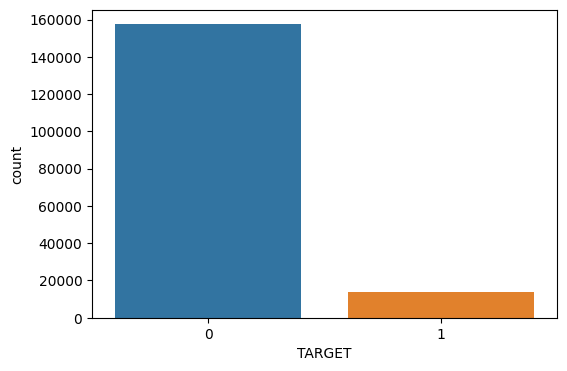

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x="TARGET")
plt.show()

#### 1.6.2 "NAME_CONTRACT_TYPE"と債務不履行リスクの関係

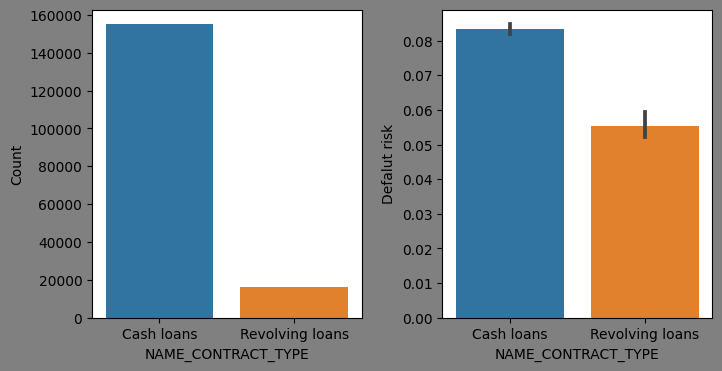

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="NAME_CONTRACT_TYPE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="NAME_CONTRACT_TYPE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.3 "CODE_GENDER"と債務不履行リスクの関係

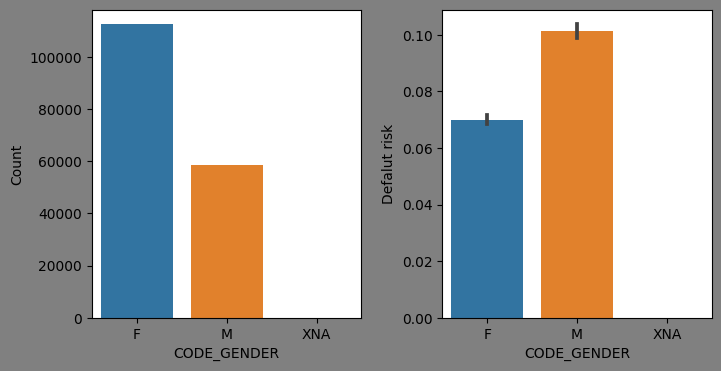

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="CODE_GENDER", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="CODE_GENDER", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["CODE_GENDER"].value_counts()

F      112549
M       58649
XNA         4
Name: CODE_GENDER, dtype: int64

In [ ]:
test["CODE_GENDER"].value_counts()

F    39916
M    21584
Name: CODE_GENDER, dtype: int64

#### 1.6.4 "FLAG_OWN_CAR"と債務不履行リスクの関係

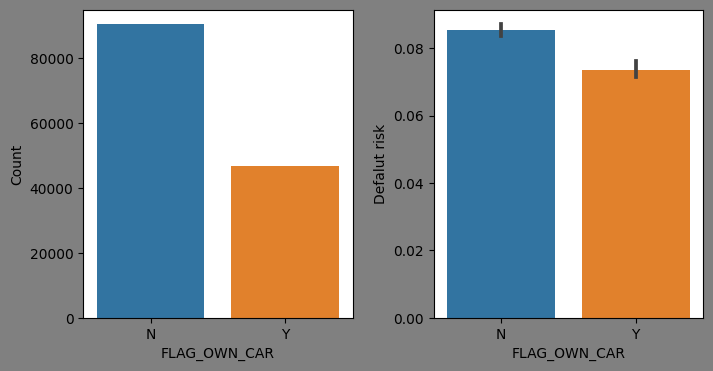

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_OWN_CAR", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_OWN_CAR", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.5 "FLAG_OWN_REALTY"と債務不履行リスクの関係

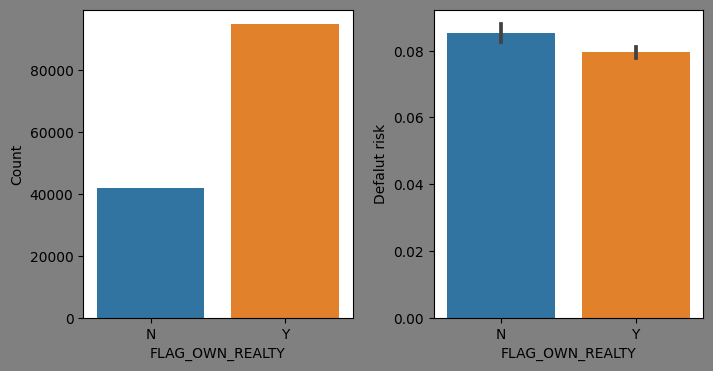

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_OWN_REALTY", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_OWN_REALTY", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.6 "CNT_CHILDREN"と債務不履行リスクの関係

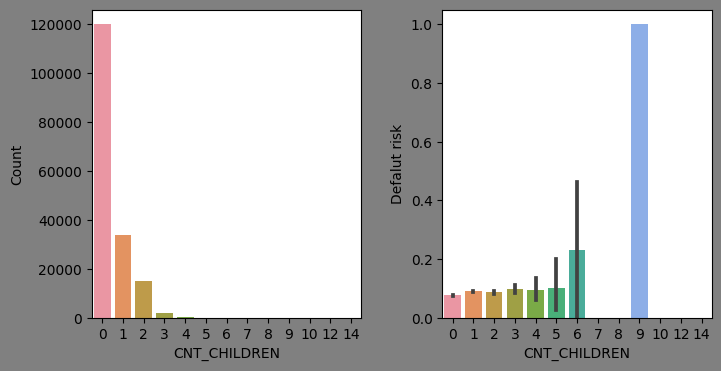

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="CNT_CHILDREN", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="CNT_CHILDREN", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.7 "AMT_INCOME_TOTAL"の分布

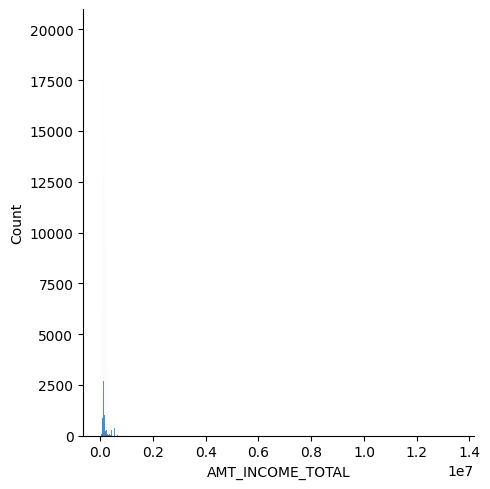

In [ ]:
sns.displot(data=train, x="AMT_INCOME_TOTAL")
plt.show()

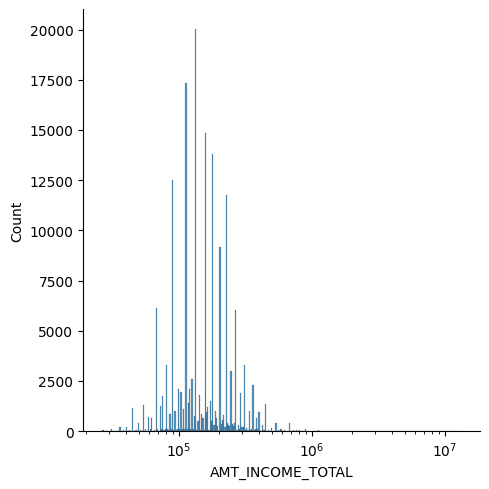

In [ ]:
# 対数変換してグラフ表示
sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
plt.show()

In [ ]:
# "AMT_INCOME_TOTAL"の値の種類を確認
len(train["AMT_INCOME_TOTAL"].unique())

1641

In [ ]:
# "AMT_INCOME_TOTAL"の上位10個
train["AMT_INCOME_TOTAL"].value_counts().head(10)

135000.0    19969
112500.0    17320
157500.0    14772
180000.0    13791
90000.0     12481
225000.0    11573
202500.0     9128
67500.0      6130
270000.0     6006
81000.0      3295
Name: AMT_INCOME_TOTAL, dtype: int64

#### 1.6.8 "AMT_CREDIT"の分布

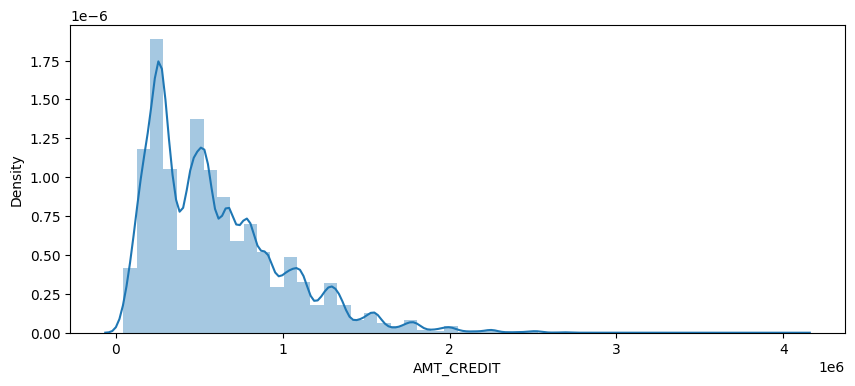

In [ ]:
plt.figure(figsize=(10, 4))
sns.distplot(train["AMT_CREDIT"])
plt.show()

#### 1.6.9 "AMT_ANNUITY"の分布

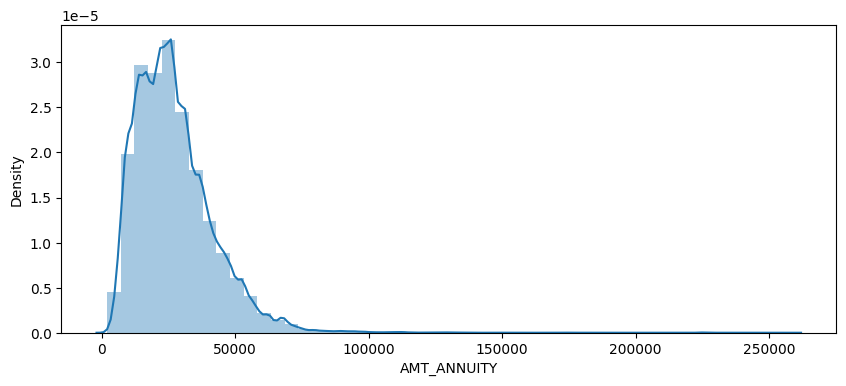

In [ ]:
plt.figure(figsize=(10, 4))
sns.distplot(train["AMT_ANNUITY"].dropna())
plt.show()

#### 1.6.10 "AMT_GOODS_PRICE"の分布

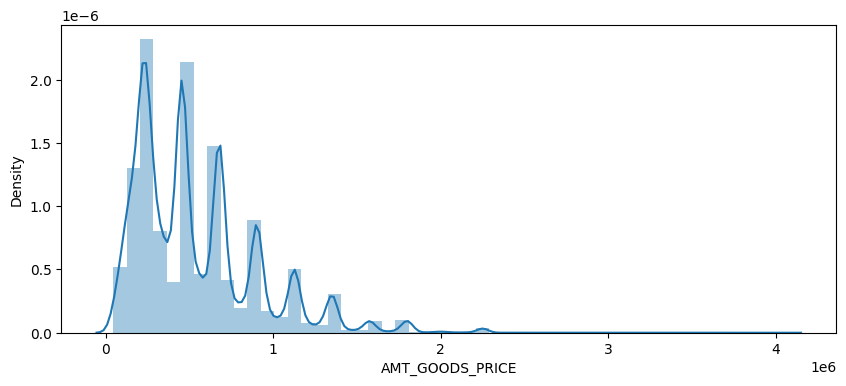

In [ ]:
plt.figure(figsize=(10, 4))
sns.distplot(train["AMT_GOODS_PRICE"].dropna())
plt.show()

#### 1.6.11 "NAME_TYPE_SUITE"と債務不履行リスクの関係

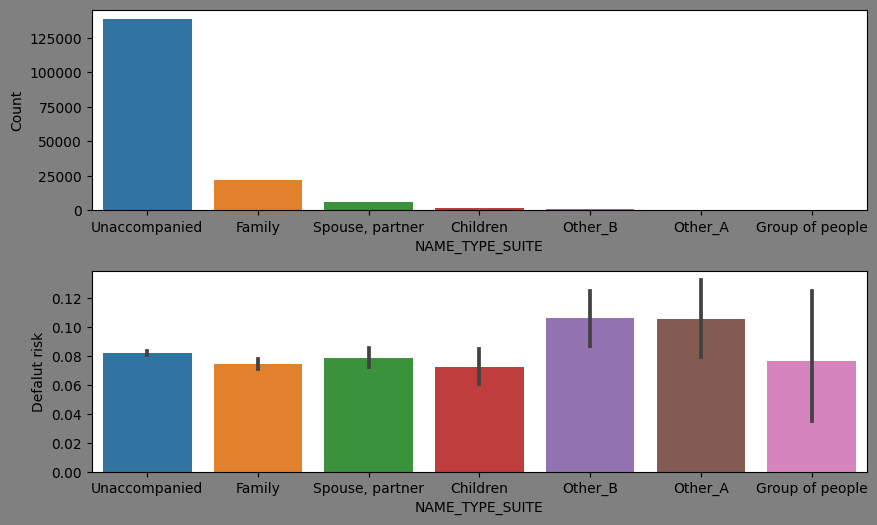

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(10, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="NAME_TYPE_SUITE", data=train, order=train["NAME_TYPE_SUITE"].value_counts().index, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="NAME_TYPE_SUITE", y="TARGET", data=train, order=train["NAME_TYPE_SUITE"].value_counts().index, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["NAME_TYPE_SUITE"].value_counts()

Unaccompanied      138445
Family              22356
Spouse, partner      6288
Children             1775
Other_B               955
Other_A               492
Group of people       144
Name: NAME_TYPE_SUITE, dtype: int64

In [ ]:
test["NAME_TYPE_SUITE"].value_counts()

Unaccompanied      49771
Family              7860
Spouse, partner     2348
Children             671
Other_B              359
Other_A              185
Group of people       58
Name: NAME_TYPE_SUITE, dtype: int64

#### 1.6.12 "NAME_INCOME_TYPE"と債務不履行リスクの関係

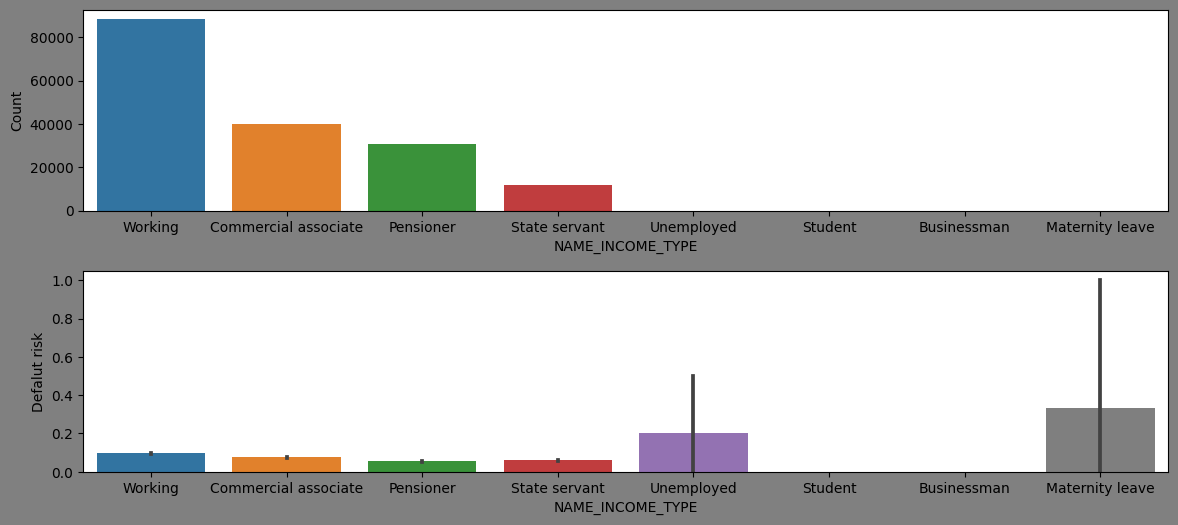

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(14, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="NAME_INCOME_TYPE", data=train, order=train["NAME_INCOME_TYPE"].value_counts().index, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="NAME_INCOME_TYPE", y="TARGET", data=train, order=train["NAME_INCOME_TYPE"].value_counts().index, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["NAME_INCOME_TYPE"].value_counts()

Working                 88268
Commercial associate    40007
Pensioner               30895
State servant           12007
Unemployed                 10
Student                     9
Businessman                 3
Maternity leave             3
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
test["NAME_INCOME_TYPE"].value_counts()

Working                 32460
Commercial associate    14253
Pensioner               10560
State servant            4215
Unemployed                  6
Student                     4
Maternity leave             1
Businessman                 1
Name: NAME_INCOME_TYPE, dtype: int64

#### 1.6.13 "NAME_EDUCATION_TYPE"と債務不履行リスクの関係

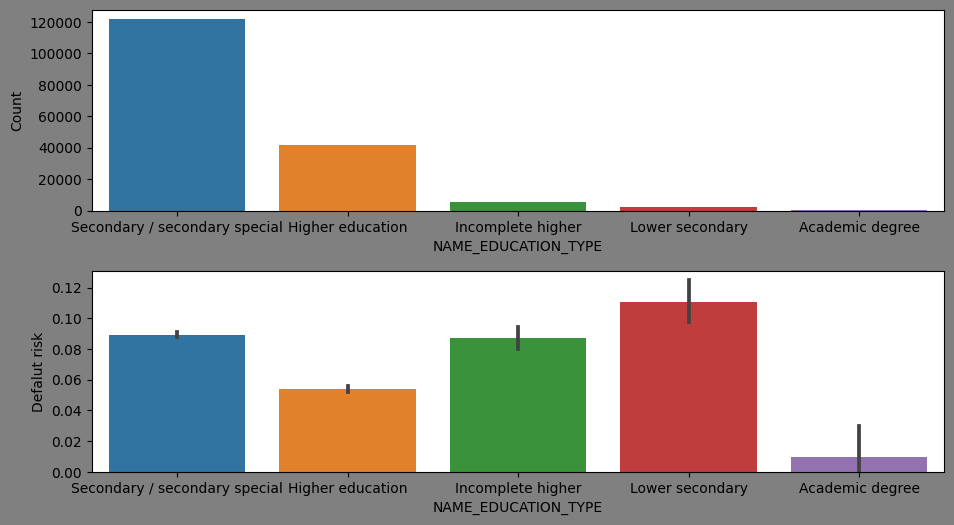

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(11, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="NAME_EDUCATION_TYPE", data=train, order=train["NAME_EDUCATION_TYPE"].value_counts().index, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="NAME_EDUCATION_TYPE", y="TARGET", data=train, order=train["NAME_EDUCATION_TYPE"].value_counts().index, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["NAME_EDUCATION_TYPE"].value_counts()

Secondary / secondary special    121612
Higher education                  41645
Incomplete higher                  5711
Lower secondary                    2133
Academic degree                     101
Name: NAME_EDUCATION_TYPE, dtype: int64

In [ ]:
test["NAME_EDUCATION_TYPE"].value_counts()

Secondary / secondary special    44154
Higher education                 14474
Incomplete higher                 2087
Lower secondary                    761
Academic degree                     24
Name: NAME_EDUCATION_TYPE, dtype: int64

#### 1.6.14 "NAME_FAMILY_STATUS"と債務不履行リスクの関係

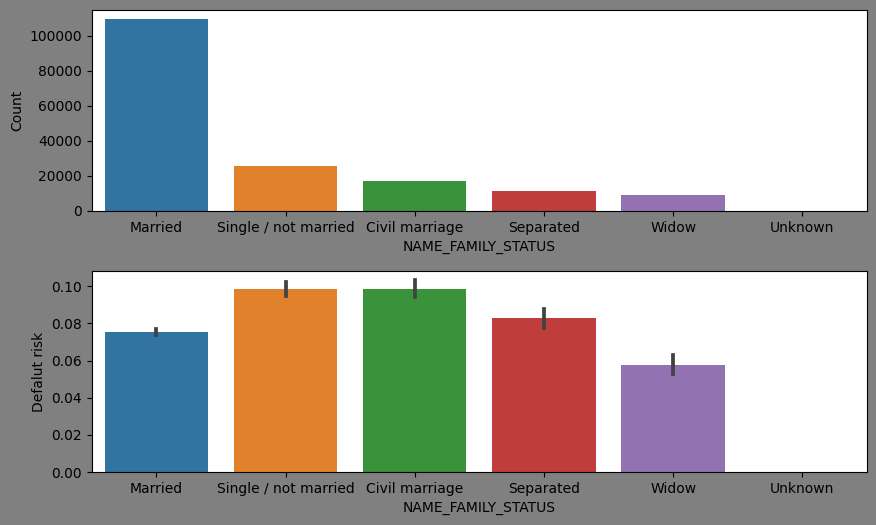

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(10, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="NAME_FAMILY_STATUS", data=train, order=train["NAME_FAMILY_STATUS"].value_counts().index, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="NAME_FAMILY_STATUS", y="TARGET", data=train, order=train["NAME_FAMILY_STATUS"].value_counts().index, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["NAME_FAMILY_STATUS"].value_counts()

Married                 109323
Single / not married     25285
Civil marriage           16652
Separated                10988
Widow                     8952
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [ ]:
test["NAME_FAMILY_STATUS"].value_counts()

Married                 38946
Single / not married     9334
Civil marriage           6098
Separated                4008
Widow                    3114
Name: NAME_FAMILY_STATUS, dtype: int64

#### 1.6.15 "NAME_HOUSING_TYPE"と債務不履行リスクの関係

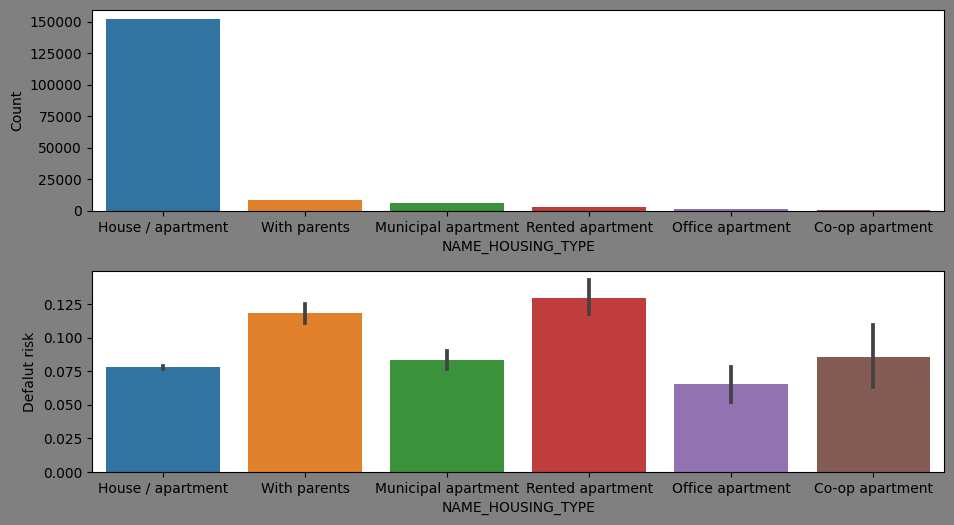

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(11, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="NAME_HOUSING_TYPE", data=train, order=train["NAME_HOUSING_TYPE"].value_counts().index, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="NAME_HOUSING_TYPE", y="TARGET", data=train, order=train["NAME_HOUSING_TYPE"].value_counts().index, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["NAME_HOUSING_TYPE"].value_counts()

House / apartment      151916
With parents             8263
Municipal apartment      6225
Rented apartment         2734
Office apartment         1444
Co-op apartment           620
Name: NAME_HOUSING_TYPE, dtype: int64

In [ ]:
test["NAME_HOUSING_TYPE"].value_counts()

House / apartment      54377
With parents            3071
Municipal apartment     2290
Rented apartment        1003
Office apartment         522
Co-op apartment          237
Name: NAME_HOUSING_TYPE, dtype: int64

#### 1.6.16 "REGION_POPULATION_RELATIVE"の分布

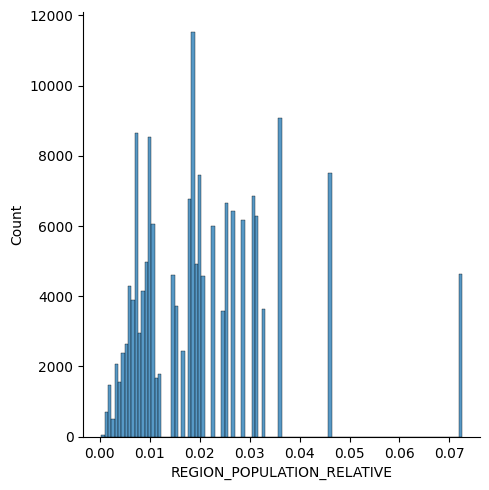

In [ ]:
sns.displot(train["REGION_POPULATION_RELATIVE"])
plt.show()

#### 1.6.17 "DAYS_BIRTH"の分布

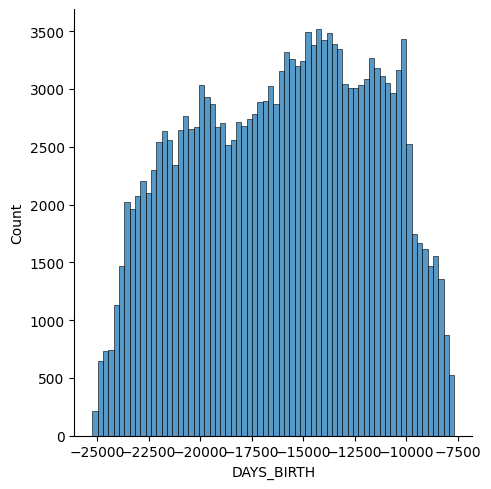

In [ ]:
sns.displot(train["DAYS_BIRTH"])
plt.show()

#### 1.6.18 "DAYS_EMPLOYED"の分布

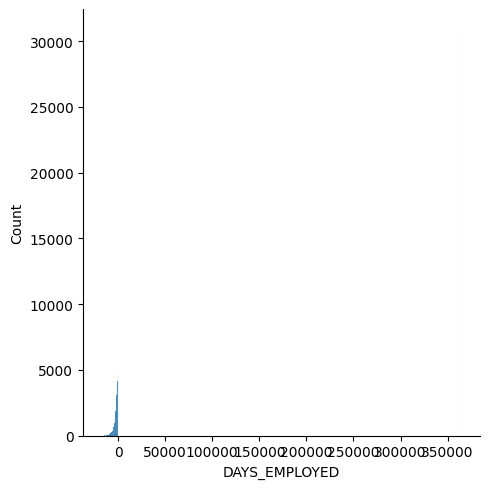

In [ ]:
sns.displot(train["DAYS_EMPLOYED"])
plt.show()

In [ ]:
train["DAYS_EMPLOYED"].value_counts()

 365243    30898
-200         106
-224          90
-384          85
-230          84
           ...  
-10308         1
-6787          1
-14640         1
-8816          1
-10945         1
Name: DAYS_EMPLOYED, Length: 11178, dtype: int64

In [ ]:
all[all["DAYS_EMPLOYED"] > 0]["DAYS_EMPLOYED"].value_counts()

365243    41463
Name: DAYS_EMPLOYED, dtype: int64

#### 1.6.19 "DAYS_REGISTRATION"の分布

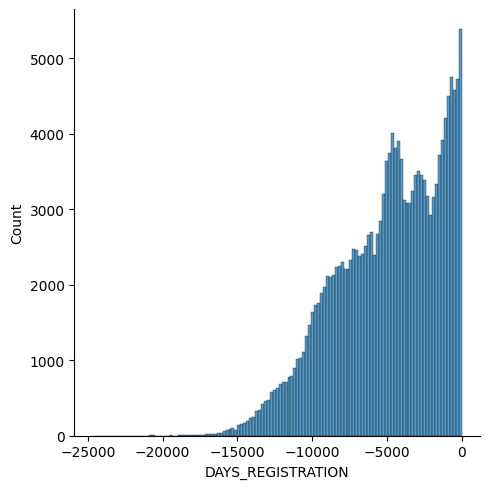

In [ ]:
sns.displot(train["DAYS_REGISTRATION"])
plt.show()

#### 1.6.20 "DAYS_ID_PUBLISH"の分布

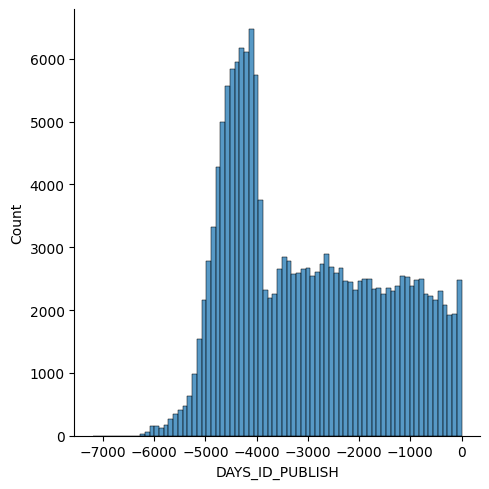

In [ ]:
sns.displot(train["DAYS_ID_PUBLISH"])
plt.show()

#### 1.6.21 "OWN_CAR_AGE"の分布

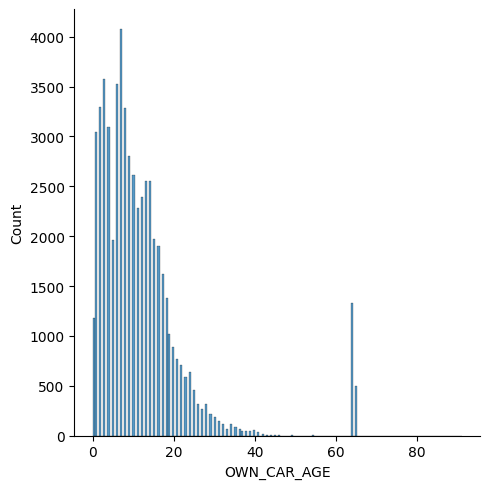

In [ ]:
sns.displot(train["OWN_CAR_AGE"])
plt.show()

In [ ]:
train[train["OWN_CAR_AGE"] >= 50]["OWN_CAR_AGE"].value_counts()

64.0    1331
65.0     494
54.0       5
57.0       1
55.0       1
91.0       1
Name: OWN_CAR_AGE, dtype: int64

In [ ]:
test[test["OWN_CAR_AGE"] >= 50]["OWN_CAR_AGE"].value_counts()

64.0    498
65.0    173
51.0      3
55.0      2
54.0      1
91.0      1
69.0      1
50.0      1
Name: OWN_CAR_AGE, dtype: int64

#### 1.6.22 "FLAG_MOBIL"と債務不履行リスクの関係

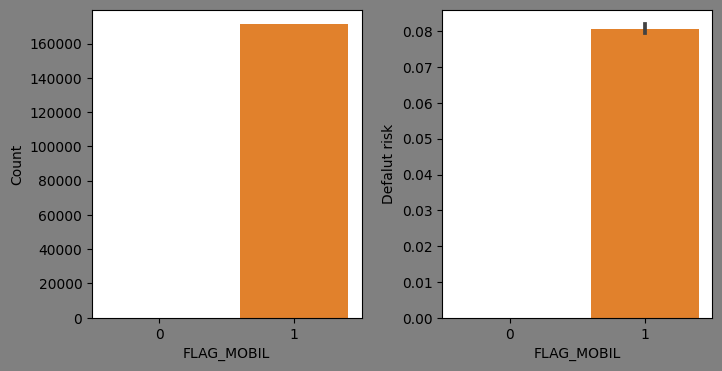

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_MOBIL", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_MOBIL", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["FLAG_MOBIL"].value_counts()

1    171201
0         1
Name: FLAG_MOBIL, dtype: int64

In [ ]:
test["FLAG_MOBIL"].value_counts()

1    61500
Name: FLAG_MOBIL, dtype: int64

#### 1.6.23 "FLAG_EMP_PHONE"と債務不履行リスクの関係

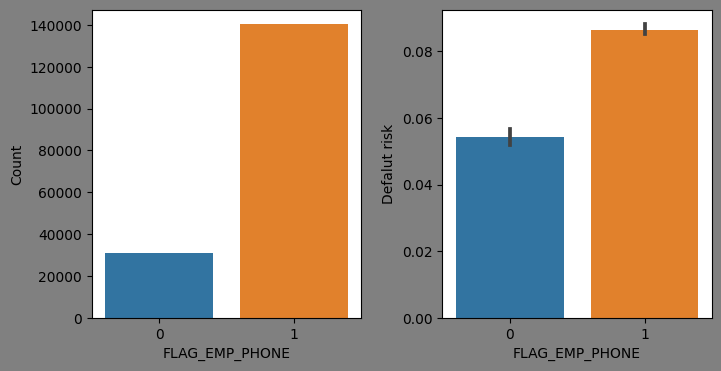

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_EMP_PHONE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_EMP_PHONE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.24 "FLAG_WORK_PHONE"と債務不履行リスクの関係

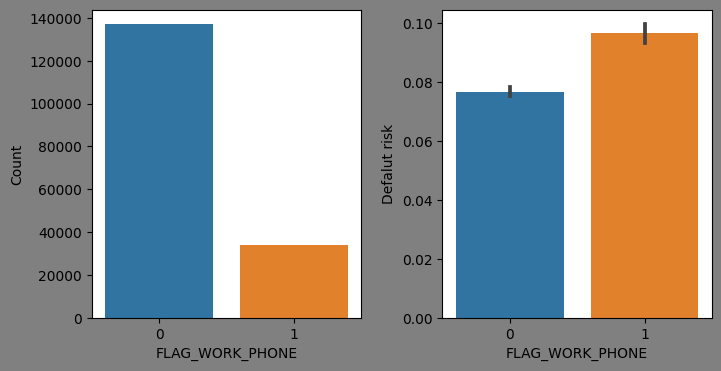

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_WORK_PHONE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_WORK_PHONE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.25 "FLAG_CONT_MOBILE"と債務不履行リスクの関係

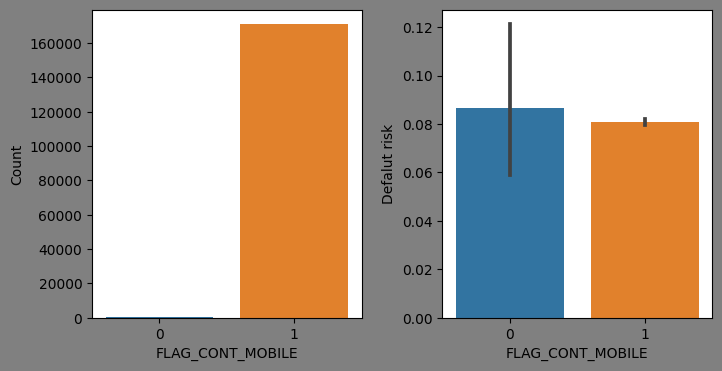

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_CONT_MOBILE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_CONT_MOBILE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["FLAG_CONT_MOBILE"].value_counts()

1    170913
0       289
Name: FLAG_CONT_MOBILE, dtype: int64

In [ ]:
test["FLAG_CONT_MOBILE"].value_counts()

1    61363
0      137
Name: FLAG_CONT_MOBILE, dtype: int64

#### 1.6.26 "FLAG_PHONE"の分布

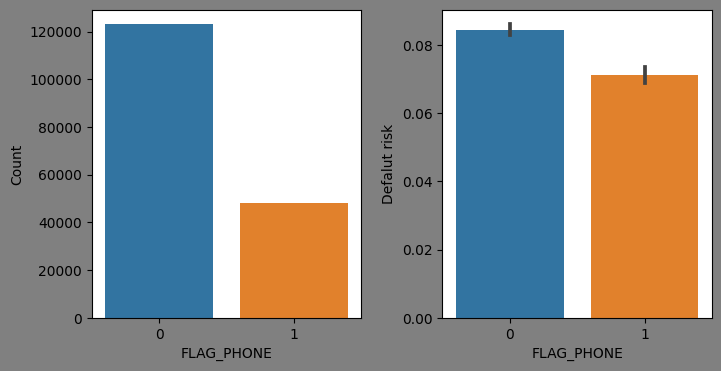

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_PHONE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_PHONE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.27 "FLAG_EMAIL"と債務不履行リスクの関係

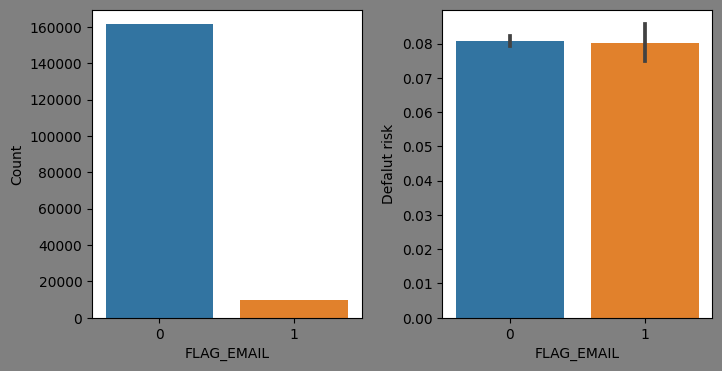

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="FLAG_EMAIL", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="FLAG_EMAIL", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.28 "OCCUPATION_TYPE"と債務不履行リスクの関係

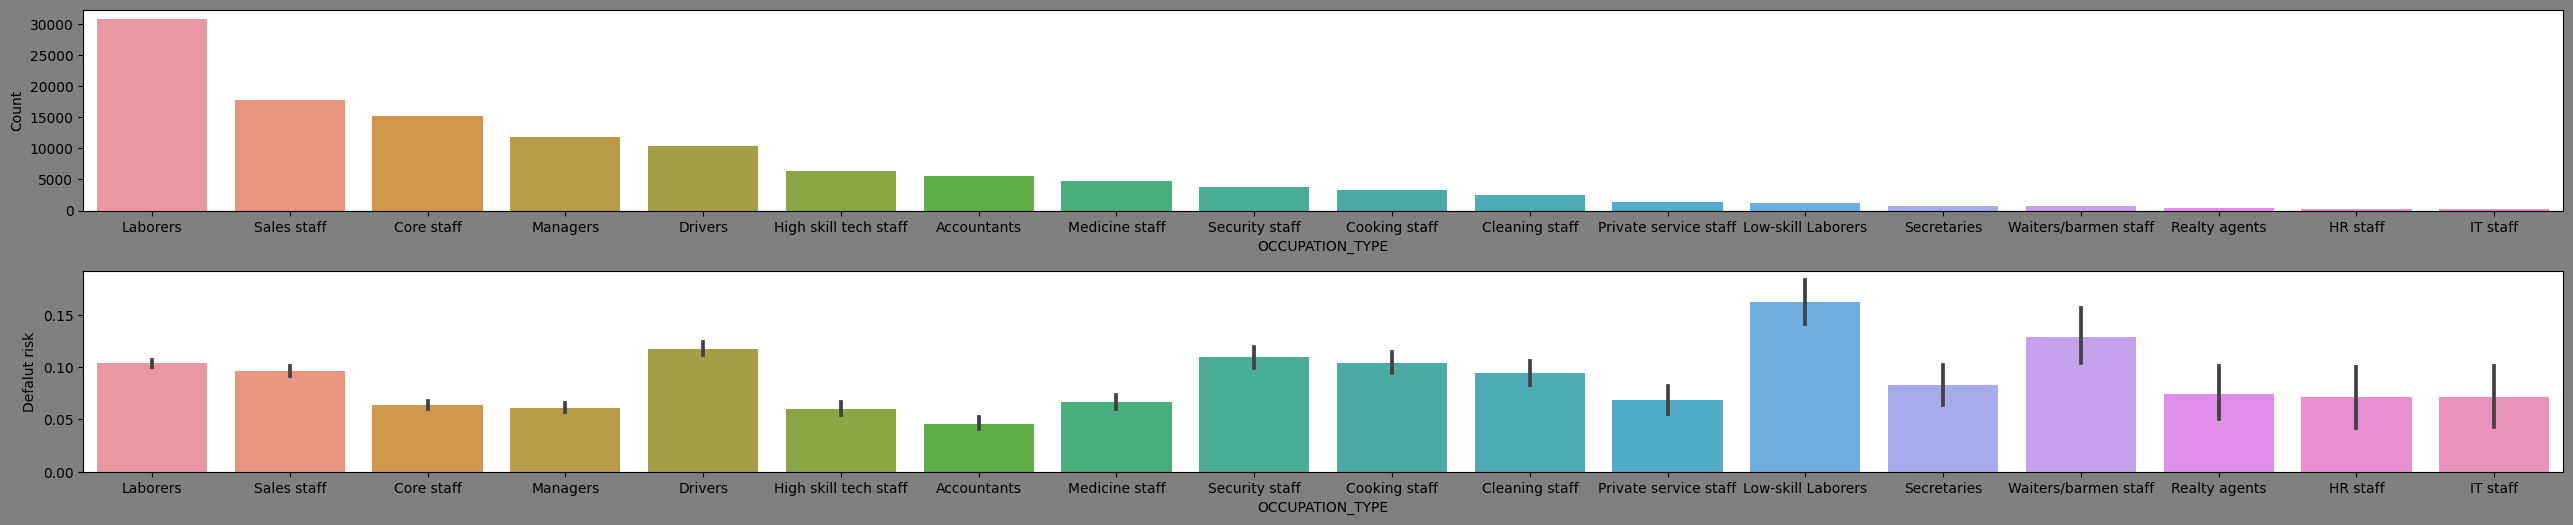

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(32, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="OCCUPATION_TYPE", data=train, order=train["OCCUPATION_TYPE"].value_counts().index, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="OCCUPATION_TYPE", y="TARGET", data=train, order=train["OCCUPATION_TYPE"].value_counts().index, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["OCCUPATION_TYPE"].value_counts()

Laborers                 30723
Sales staff              17793
Core staff               15271
Managers                 11855
Drivers                  10353
High skill tech staff     6385
Accountants               5506
Medicine staff            4744
Security staff            3752
Cooking staff             3353
Cleaning staff            2567
Private service staff     1457
Low-skill Laborers        1158
Secretaries                762
Waiters/barmen staff       747
Realty agents              416
HR staff                   309
IT staff                   306
Name: OCCUPATION_TYPE, dtype: int64

In [ ]:
test["OCCUPATION_TYPE"].value_counts()

Laborers                 11490
Sales staff               6604
Core staff                5437
Managers                  4245
Drivers                   3844
High skill tech staff     2219
Accountants               1882
Medicine staff            1668
Security staff            1378
Cooking staff             1183
Cleaning staff             951
Private service staff      542
Low-skill Laborers         468
Waiters/barmen staff       287
Secretaries                204
Realty agents              147
HR staff                   110
IT staff                   107
Name: OCCUPATION_TYPE, dtype: int64

#### 1.6.29 "CNT_FAM_MEMBERS"と債務不履行リスクの関係

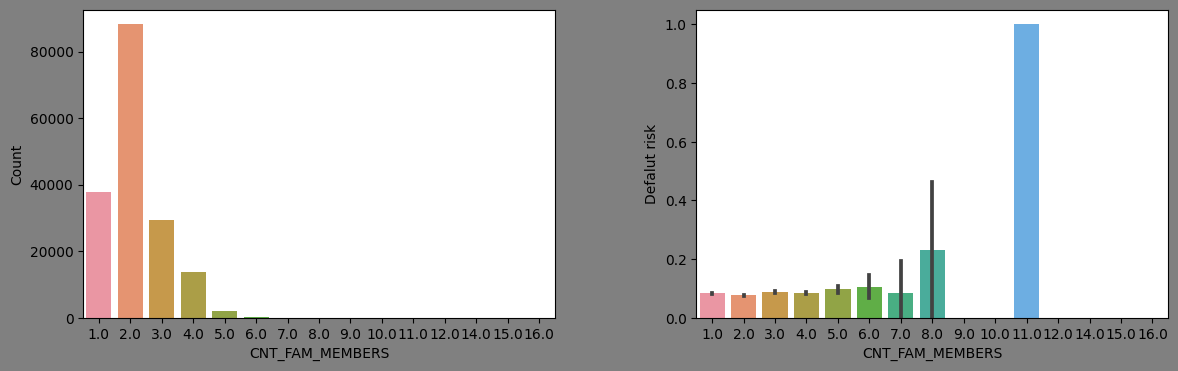

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(14, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="CNT_FAM_MEMBERS", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="CNT_FAM_MEMBERS", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

In [ ]:
train["CNT_FAM_MEMBERS"].value_counts()

2.0     88165
1.0     37766
3.0     29284
4.0     13801
5.0      1903
6.0       220
7.0        36
8.0        13
9.0         4
12.0        2
10.0        2
11.0        1
14.0        1
15.0        1
16.0        1
Name: CNT_FAM_MEMBERS, dtype: int64

#### 1.6.30 "REGION_RATING_CLIENT"と債務不履行リスクの関係

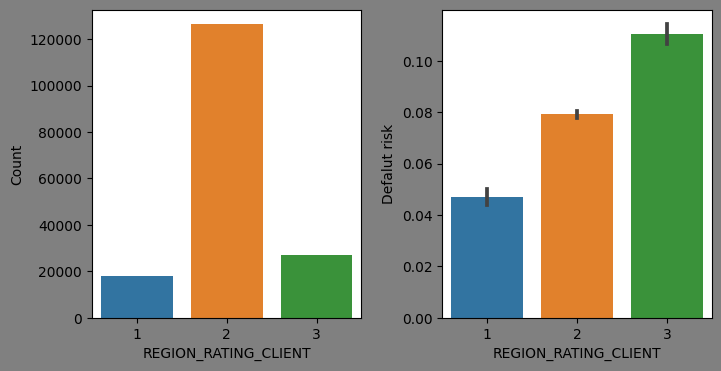

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="REGION_RATING_CLIENT", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="REGION_RATING_CLIENT", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.31 "REGION_RATING_CLIENT_W_CITY"と債務不履行リスクの関係

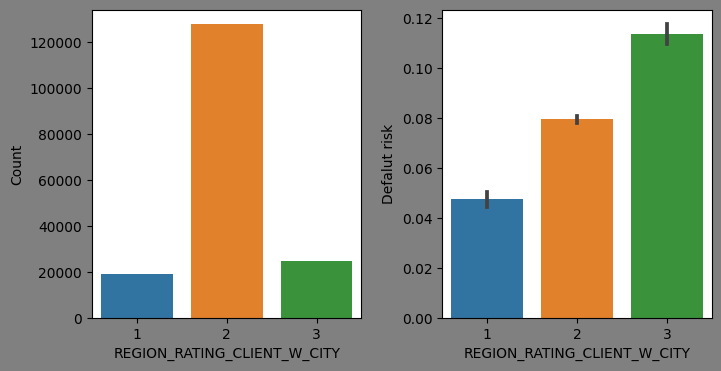

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="REGION_RATING_CLIENT_W_CITY", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="REGION_RATING_CLIENT_W_CITY", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.32 "REG_REGION_NOT_LIVE_REGION"と債務不履行リスクの関係

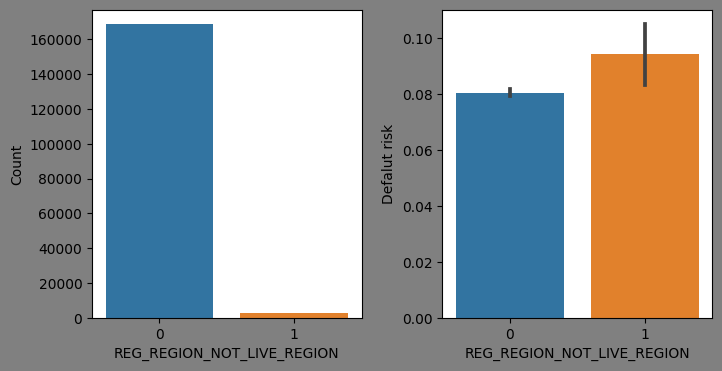

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="REG_REGION_NOT_LIVE_REGION", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="REG_REGION_NOT_LIVE_REGION", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.33 "REG_REGION_NOT_WORK_REGION"と債務不履行リスクの関係

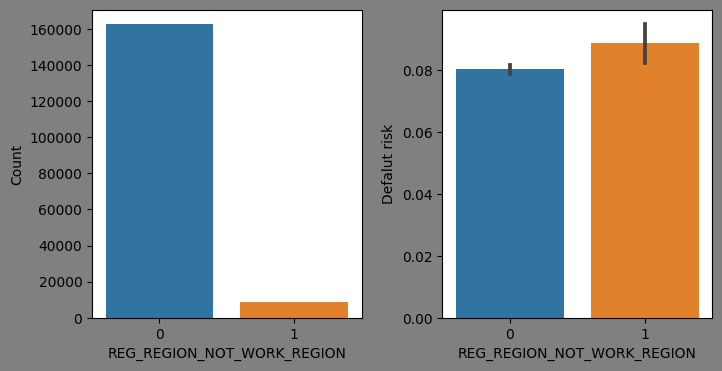

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="REG_REGION_NOT_WORK_REGION", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="REG_REGION_NOT_WORK_REGION", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.34 "LIVE_REGION_NOT_WORK_REGION"と債務不履行リスクの関係

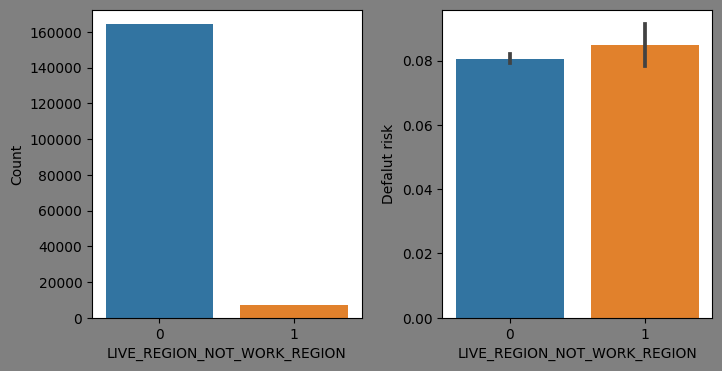

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="LIVE_REGION_NOT_WORK_REGION", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="LIVE_REGION_NOT_WORK_REGION", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.35 "REG_CITY_NOT_LIVE_CITY"と債務不履行リスクの関係

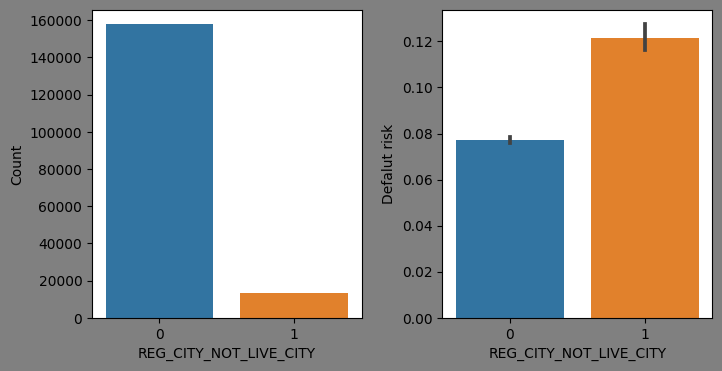

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="REG_CITY_NOT_LIVE_CITY", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="REG_CITY_NOT_LIVE_CITY", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.36 "REG_CITY_NOT_WORK_CITY"と債務不履行リスクの関係

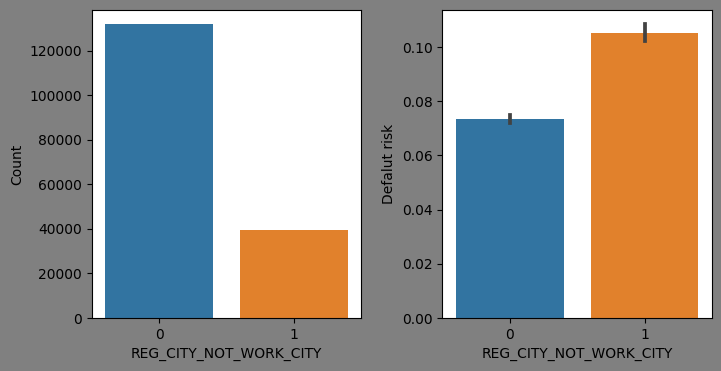

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="REG_CITY_NOT_WORK_CITY", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="REG_CITY_NOT_WORK_CITY", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.37 "LIVE_CITY_NOT_WORK_CITY"と債務不履行リスクの関係

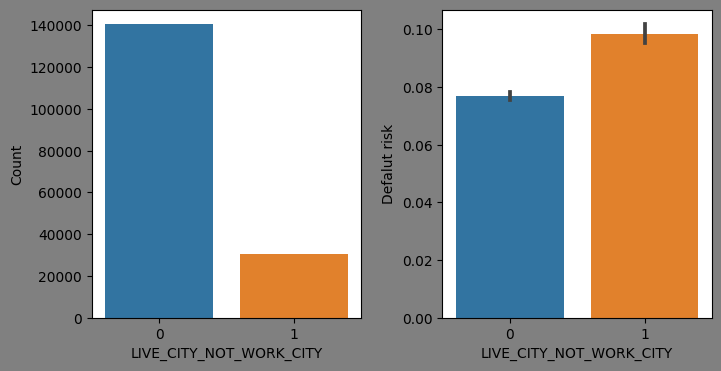

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="LIVE_CITY_NOT_WORK_CITY", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="LIVE_CITY_NOT_WORK_CITY", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.38 "ORGANIZATION_TYPE"と債務不履行リスクの関係

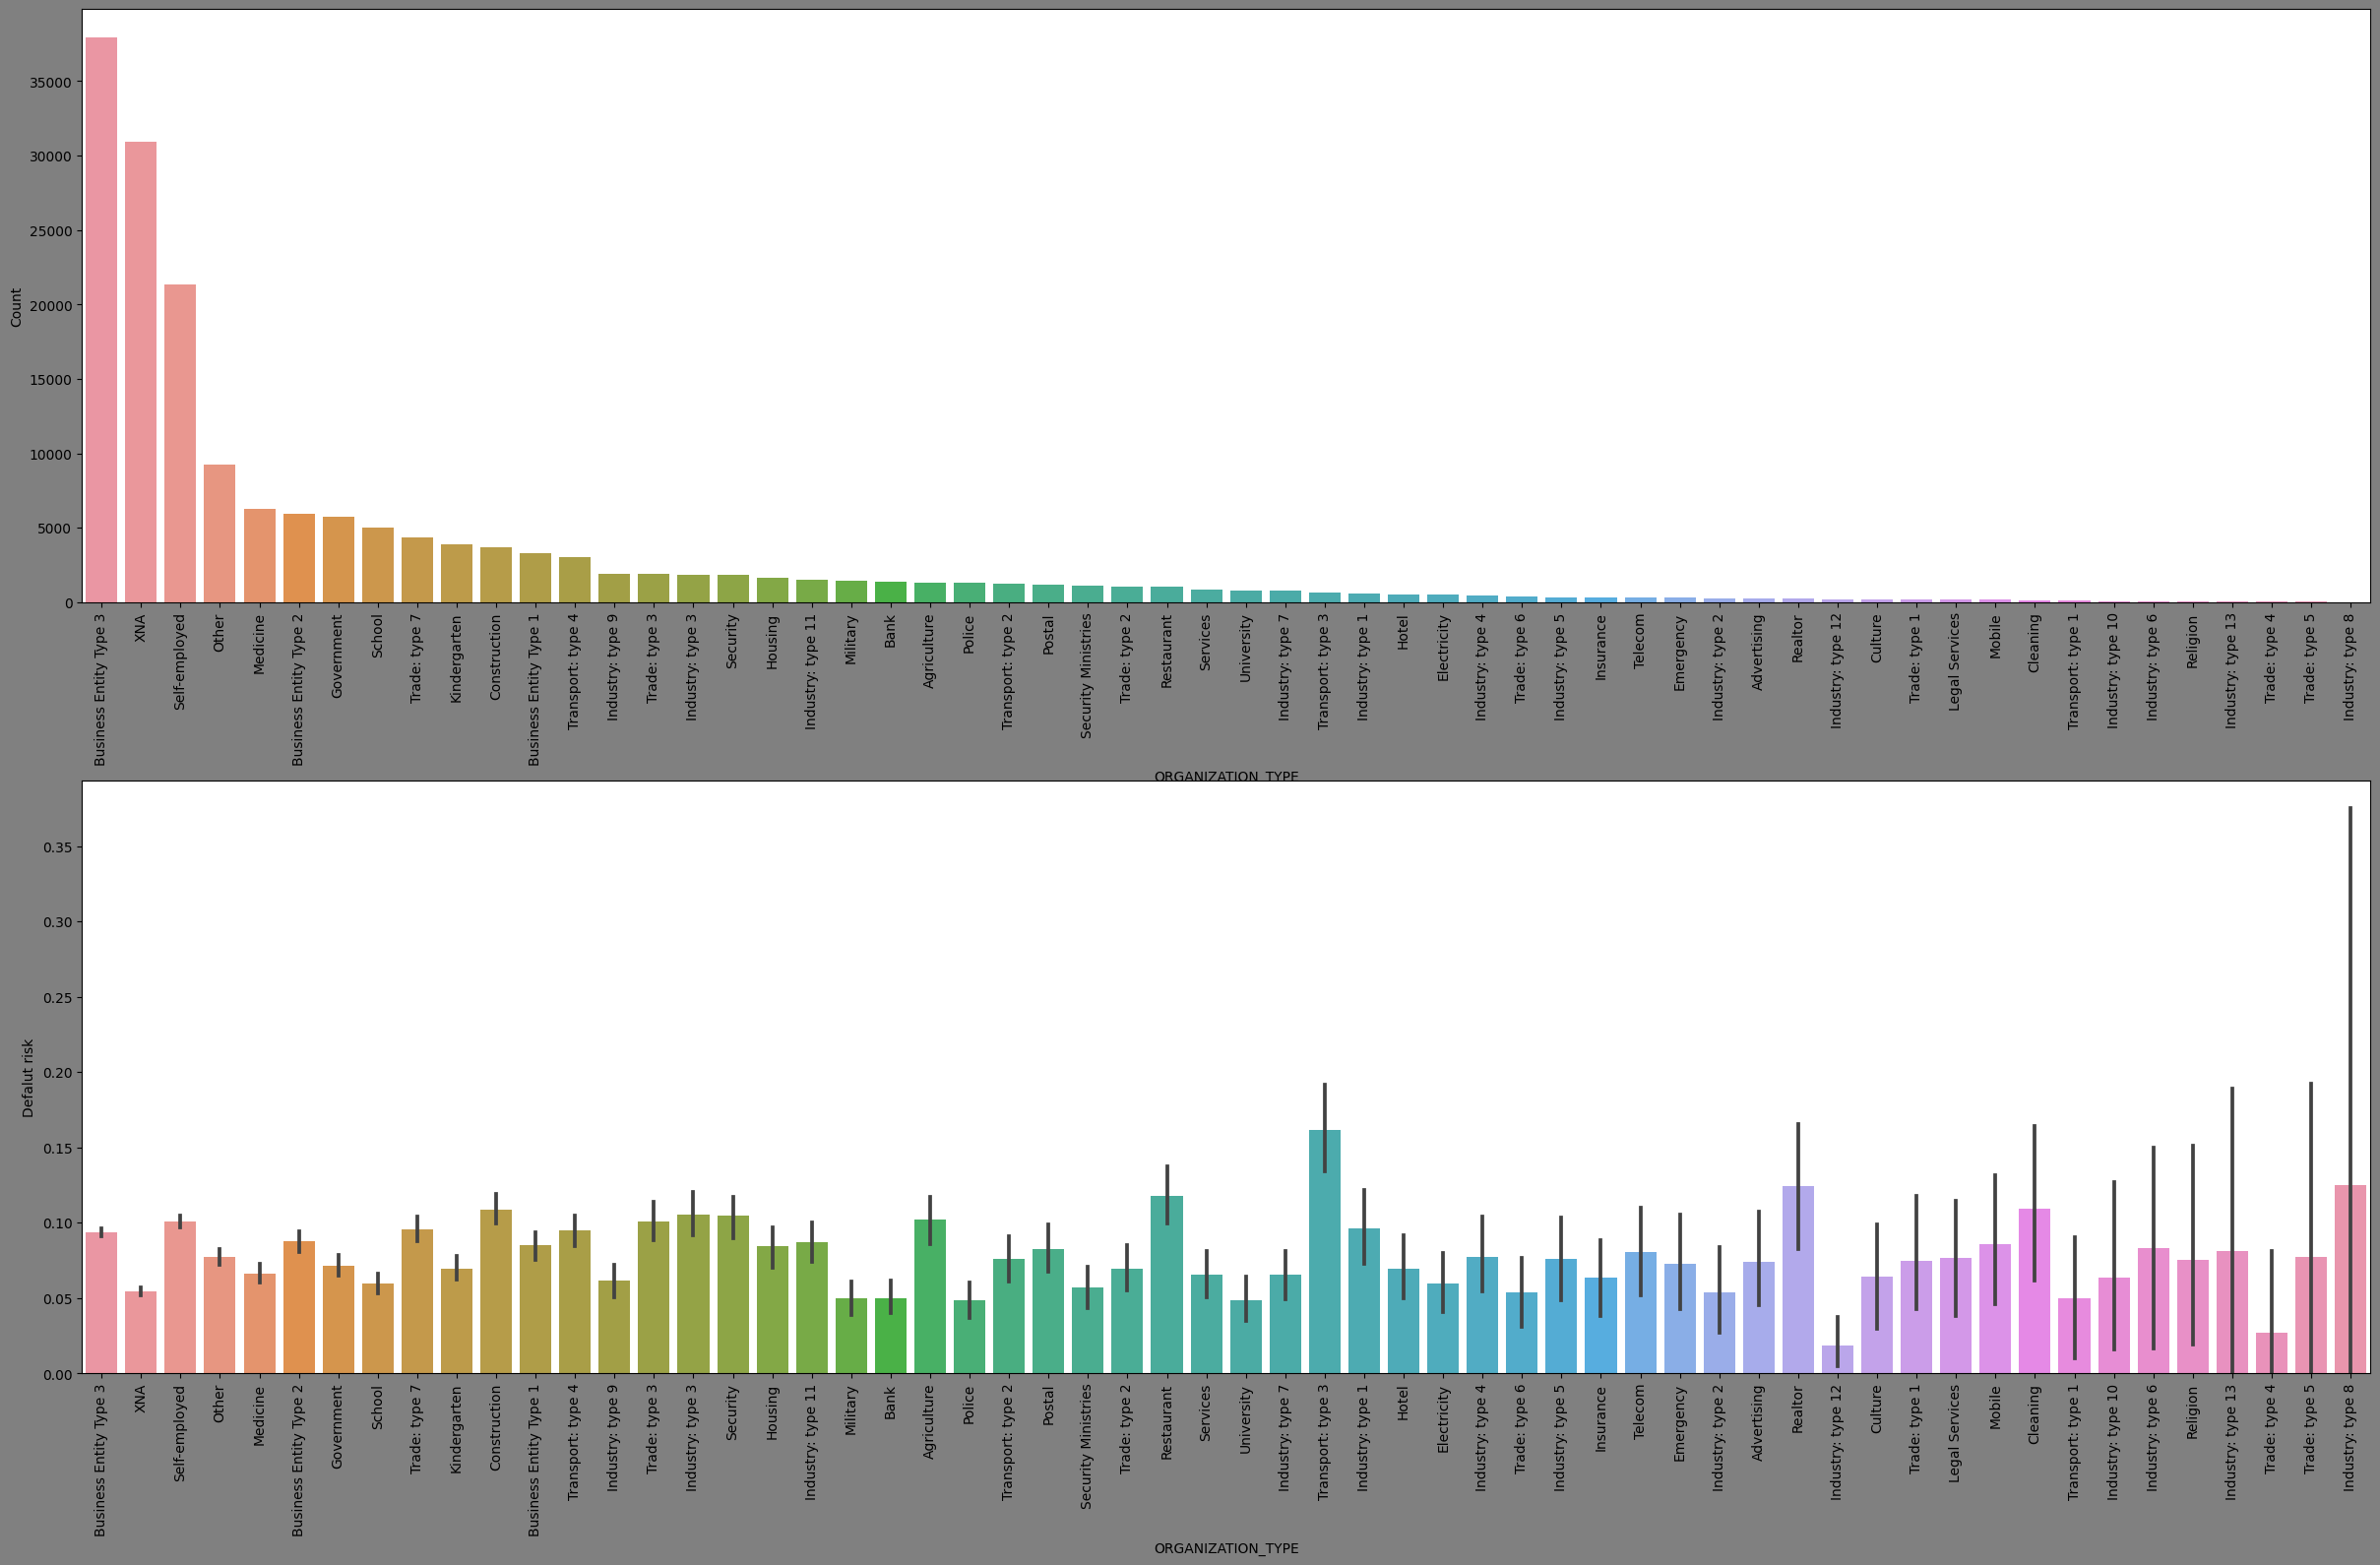

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(30, 18), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="ORGANIZATION_TYPE", data=train, order=train["ORGANIZATION_TYPE"].value_counts().index, ax=ax[0])
ax[0].set_ylabel("Count")
ax[0].tick_params(axis="x", rotation=90)
sns.barplot(x="ORGANIZATION_TYPE", y="TARGET", data=train, order=train["ORGANIZATION_TYPE"].value_counts().index, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
ax[1].tick_params(axis="x", rotation=90)
plt.show()

In [ ]:
train["ORGANIZATION_TYPE"].value_counts()

Business Entity Type 3    37943
XNA                       30898
Self-employed             21340
Other                      9272
Medicine                   6272
Business Entity Type 2     5923
Government                 5721
School                     4991
Trade: type 7              4336
Kindergarten               3866
Construction               3700
Business Entity Type 1     3322
Transport: type 4          3004
Industry: type 9           1893
Trade: type 3              1885
Industry: type 3           1833
Security                   1816
Housing                    1613
Industry: type 11          1505
Military                   1452
Bank                       1385
Agriculture                1338
Police                     1279
Transport: type 2          1212
Postal                     1185
Security Ministries        1105
Trade: type 2              1035
Restaurant                 1018
Services                    872
University                  779
Industry: type 7            777
Transpor

In [ ]:
test["ORGANIZATION_TYPE"].value_counts()

Business Entity Type 3    13634
XNA                       10565
Self-employed              7949
Other                      3414
Medicine                   2180
Business Entity Type 2     2116
Government                 2074
School                     1734
Trade: type 7              1589
Construction               1465
Kindergarten               1379
Business Entity Type 1     1193
Transport: type 4          1105
Trade: type 3               769
Security                    682
Industry: type 9            677
Industry: type 3            672
Housing                     621
Industry: type 11           543
Agriculture                 522
Military                    485
Bank                        478
Transport: type 2           465
Police                      445
Postal                      425
Trade: type 2               403
Restaurant                  369
Security Ministries         367
Services                    314
Transport: type 3           269
Industry: type 7            266
Universi

#### 1.6.39 "EXT_SOURCE_1"の分布

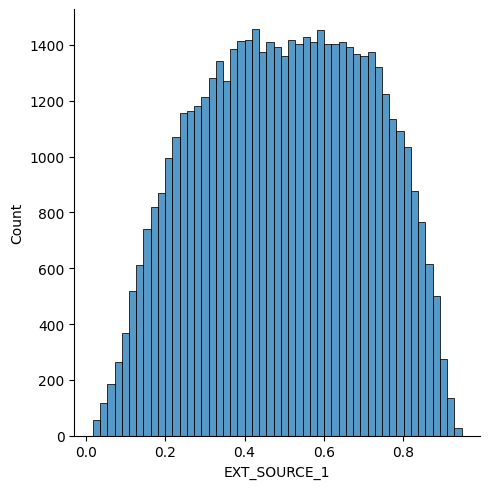

In [ ]:
sns.displot(train["EXT_SOURCE_1"])
plt.show()

#### 1.6.40 "EXT_SOURCE_2"の分布

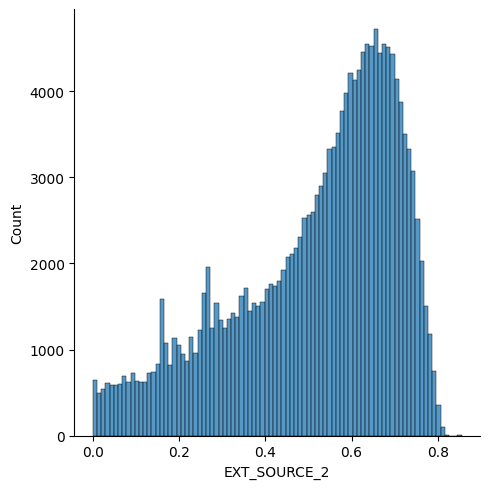

In [ ]:
sns.displot(train["EXT_SOURCE_2"])
plt.show()

#### 1.6.41 "EXT_SOURCE_3"の分布

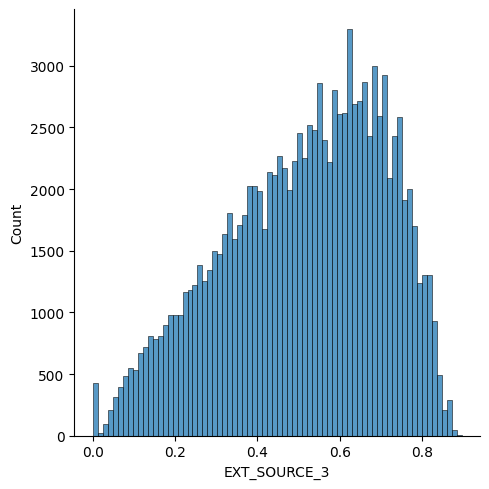

In [ ]:
sns.displot(train["EXT_SOURCE_3"])
plt.show()

#### 1.6.42 "OBS_30_CNT_SOCIAL_CIRCLE"と債務不履行リスクの関係

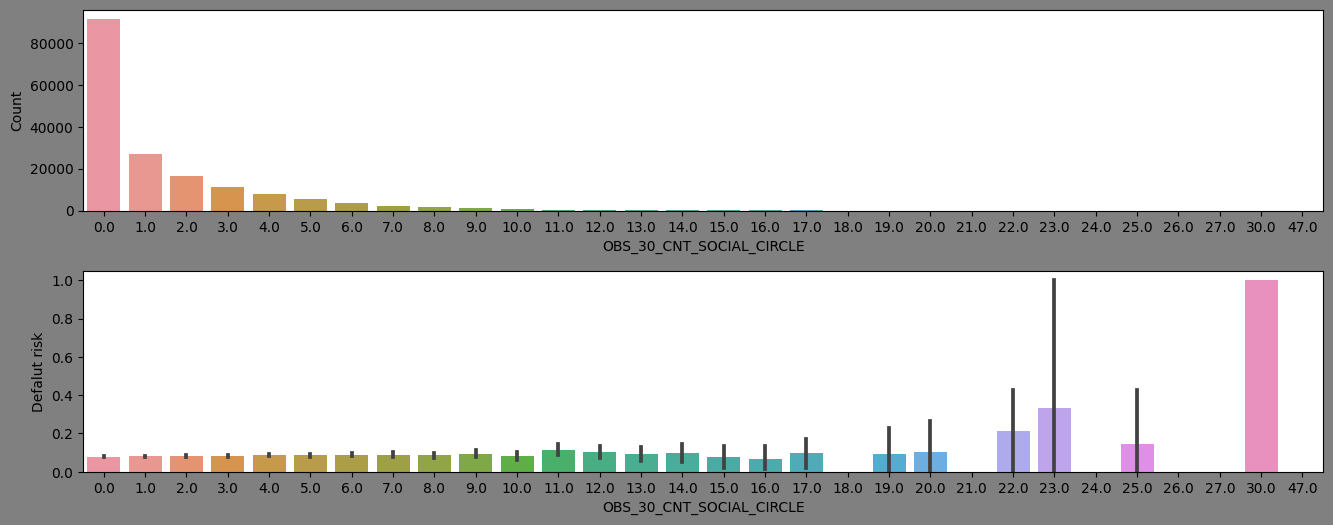

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(16, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="OBS_30_CNT_SOCIAL_CIRCLE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="OBS_30_CNT_SOCIAL_CIRCLE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.43 "DEF_30_CNT_SOCIAL_CIRCLE"と債務不履行リスクの関係

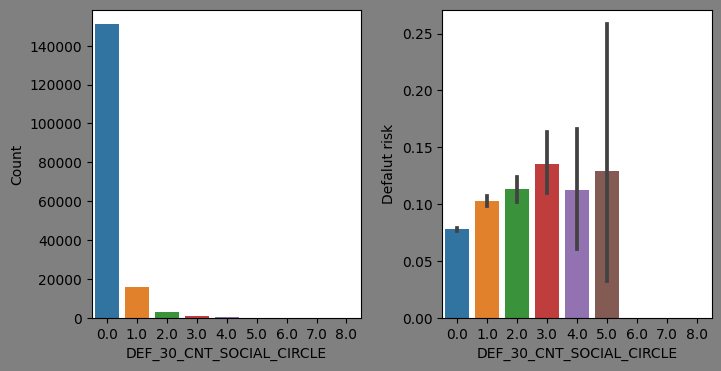

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="DEF_30_CNT_SOCIAL_CIRCLE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="DEF_30_CNT_SOCIAL_CIRCLE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.44 "OBS_60_CNT_SOCIAL_CIRCLE"と債務不履行リスクの関係

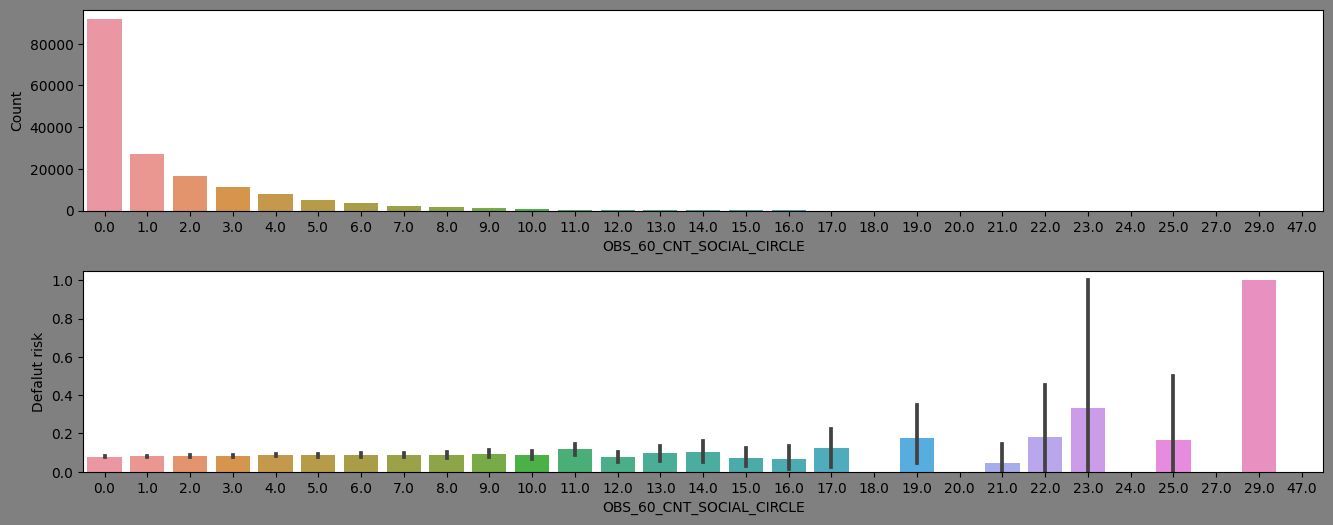

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(16, 6), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="OBS_60_CNT_SOCIAL_CIRCLE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="OBS_60_CNT_SOCIAL_CIRCLE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.45 "DEF_60_CNT_SOCIAL_CIRCLE"と債務不履行リスクの関係

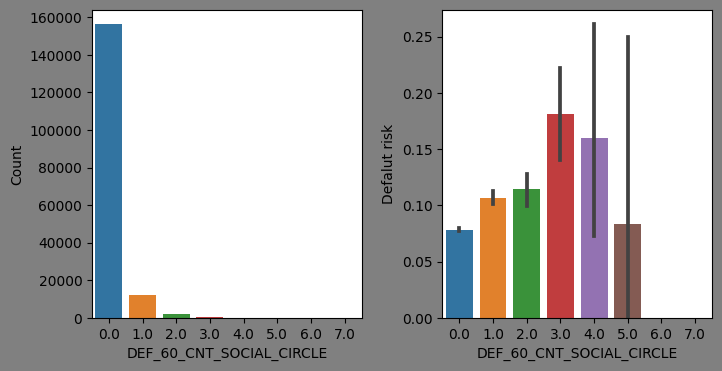

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="DEF_60_CNT_SOCIAL_CIRCLE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="DEF_60_CNT_SOCIAL_CIRCLE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.46 "DAYS_LAST_PHONE_CHANGE"の分布

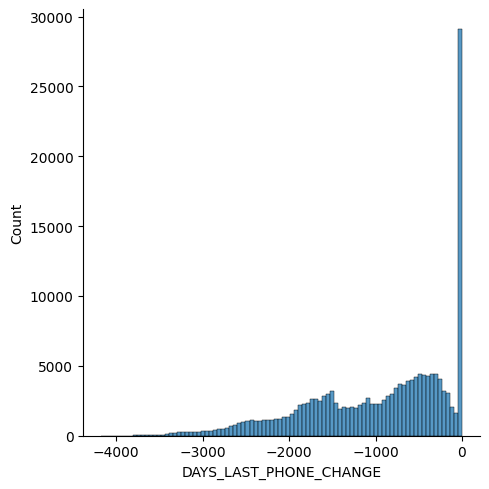

In [ ]:
sns.displot(train["DAYS_LAST_PHONE_CHANGE"])
plt.show()

In [ ]:
train[train["DAYS_LAST_PHONE_CHANGE"] == 0]["DAYS_LAST_PHONE_CHANGE"].count()

20971

In [ ]:
test[test["DAYS_LAST_PHONE_CHANGE"] == 0]["DAYS_LAST_PHONE_CHANGE"].count()

7665

#### 1.6.47 "AMT_REQ_CREDIT_BUREAU_HOUR"と債務不履行リスクの関係

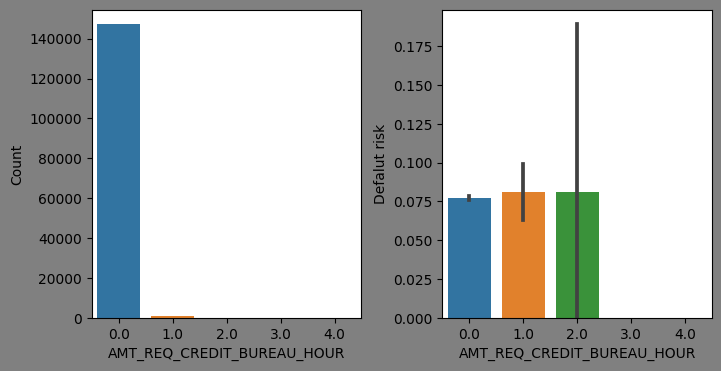

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="AMT_REQ_CREDIT_BUREAU_HOUR", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="AMT_REQ_CREDIT_BUREAU_HOUR", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.48 "AMT_REQ_CREDIT_BUREAU_MON"と債務不履行リスクの関係

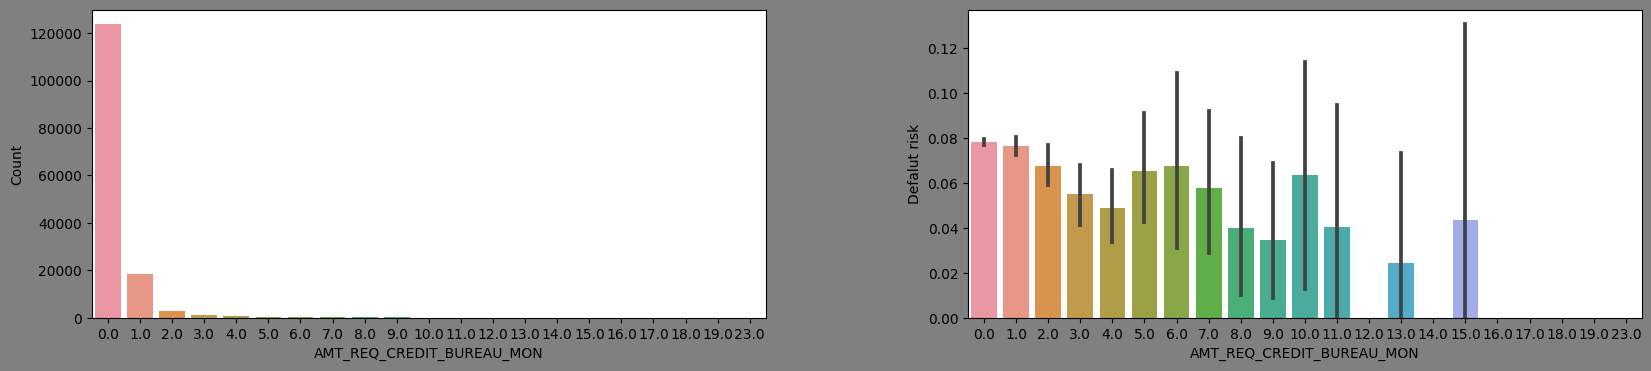

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="AMT_REQ_CREDIT_BUREAU_MON", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="AMT_REQ_CREDIT_BUREAU_MON", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.49 "AMT_REQ_CREDIT_BUREAU_QRT"と債務不履行リスクの関係

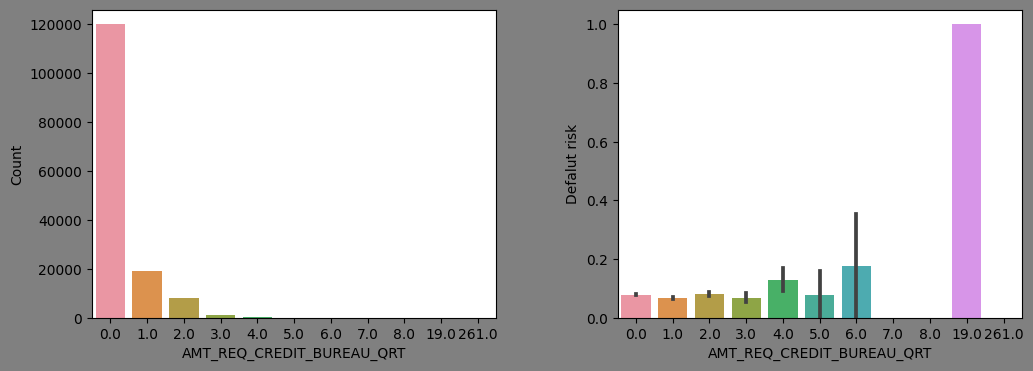

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="AMT_REQ_CREDIT_BUREAU_QRT", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="AMT_REQ_CREDIT_BUREAU_QRT", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 1.6.50 "AMT_REQ_CREDIT_BUREAU_YEAR"と債務不履行リスクの関係

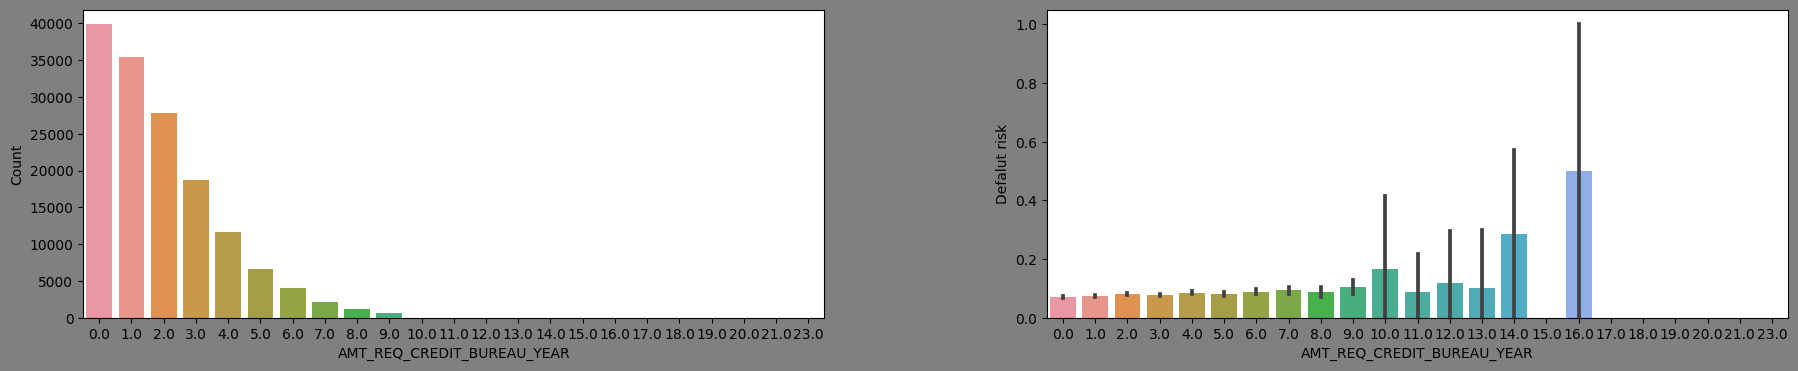

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(22, 4), facecolor="gray")
f.subplots_adjust(wspace=0.3)
sns.countplot(x="AMT_REQ_CREDIT_BUREAU_YEAR", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="AMT_REQ_CREDIT_BUREAU_YEAR", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

## 2\. データの前処理・特徴量エンジニアリング

### 2.1 データ整理

#### 2.1.1 "CODE_GENDER"列

In [ ]:
# 1.6.3より、trainデータには"XNA"が4人いるが、testデータには0人
# trainデータの"XNA"である行を削除
train = train[train["CODE_GENDER"] != "XNA"]

#### 2.1.2 "NAME_FAMILY_STATUS"列

In [ ]:
# 1.6.14より、trainデータには"Unknown"が2人いるが、testデータには0人
# trainデータの"Unknown"である行を削除
train = train[train["NAME_FAMILY_STATUS"] != "Unknown"]

#### 2.1.3 "DAYS_EMPLOYED"列

In [ ]:
# 1.6.18より、0より大きい値は365243のみ
# 外れ値とみなせるので欠損値扱い
train["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
test["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)

#### 2.1.4 "OWN_CAR_AGE"列

In [ ]:
# 1.6.21より、64,65の値が不自然に多い
# 外れ値とみなせるので欠損値扱い
train["OWN_CAR_AGE"].replace([64.0, 65.0], np.nan, inplace=True)
test["OWN_CAR_AGE"].replace([64.0, 65.0], np.nan, inplace=True)

#### 2.1.5 "DAYS_LAST_PHONE_CHANGE"列

In [ ]:
# 1.6.46より、0が異常に多く現実的に考えられない
# 外れ値とみなせるので欠損値扱い
train["DAYS_LAST_PHONE_CHANGE"].replace(0, np.nan, inplace=True)
train["DAYS_LAST_PHONE_CHANGE"].replace(0, np.nan, inplace=True)


### 2.2 欠損値の補完

In [ ]:
train[train.columns[train.isnull().any()]].isnull().sum()

FLAG_OWN_CAR                   34240
FLAG_OWN_REALTY                34240
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  161
NAME_TYPE_SUITE                  745
DAYS_EMPLOYED                  30898
OWN_CAR_AGE                   114813
OCCUPATION_TYPE                53743
EXT_SOURCE_1                  118923
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54585
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE         20972
AMT_REQ_CREDIT_BUREAU_HOUR     23115
AMT_REQ_CREDIT_BUREAU_MON      23115
AMT_REQ_CREDIT_BUREAU_QRT      23115
AMT_REQ_CREDIT_BUREAU_YEAR     23115
dtype: int64

In [ ]:
test[test.columns[test.isnull().any()]].isnull().sum()

FLAG_OWN_CAR                  12334
FLAG_OWN_REALTY               12334
AMT_ANNUITY                       3
AMT_GOODS_PRICE                  53
NAME_TYPE_SUITE                 248
DAYS_EMPLOYED                 10565
OWN_CAR_AGE                   41580
OCCUPATION_TYPE               18734
EXT_SOURCE_1                  42912
EXT_SOURCE_2                    130
EXT_SOURCE_3                  19690
OBS_30_CNT_SOCIAL_CIRCLE        181
DEF_30_CNT_SOCIAL_CIRCLE        181
OBS_60_CNT_SOCIAL_CIRCLE        181
DEF_60_CNT_SOCIAL_CIRCLE        181
AMT_REQ_CREDIT_BUREAU_HOUR     8513
AMT_REQ_CREDIT_BUREAU_MON      8513
AMT_REQ_CREDIT_BUREAU_QRT      8513
AMT_REQ_CREDIT_BUREAU_YEAR     8513
dtype: int64

In [ ]:
# train.fillna(-999, inplace = True)
# test.fillna(-999, inplace = True)

### 2.3 特徴量の作成

#### 2.3.1 "GROUP_TARGET_MEAN"列

In [ ]:
# "NAME_INCOME_TYPE"と"NAME_FAMILY_STATUS"でグループ化した"TARGET"の平均
target_mean = train[["TARGET", "NAME_INCOME_TYPE", "NAME_FAMILY_STATUS"]].groupby(["NAME_INCOME_TYPE", "NAME_FAMILY_STATUS"])["TARGET"].mean()
print(target_mean)

NAME_INCOME_TYPE      NAME_FAMILY_STATUS  
Businessman           Married                 0.000000
                      Single / not married    0.000000
Commercial associate  Civil marriage          0.090659
                      Married                 0.068779
                      Separated               0.072555
                      Single / not married    0.093081
                      Widow                   0.054487
Maternity leave       Married                 0.333333
Pensioner             Civil marriage          0.066000
                      Married                 0.051836
                      Separated               0.060333
                      Single / not married    0.052830
                      Widow                   0.056278
State servant         Civil marriage          0.075335
                      Married                 0.055429
                      Separated               0.052296
                      Single / not married    0.071002
                      

In [ ]:
train["GROUP_TARGET_MEAN"] = None
test["GROUP_TARGET_MEAN"] = None

for index, value in target_mean.items():
    income_type, family_status = index
    train.loc[(train["NAME_INCOME_TYPE"] == income_type) & (train["NAME_FAMILY_STATUS"] == family_status), "GROUP_TARGET_MEAN"] = value
    test.loc[(test["NAME_INCOME_TYPE"] == income_type) & (test["NAME_FAMILY_STATUS"] == family_status), "GROUP_TARGET_MEAN"] = value

In [ ]:
# 欠損行の確認
test[test["GROUP_TARGET_MEAN"].isnull()][["NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", "GROUP_TARGET_MEAN"]]

,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,GROUP_TARGET_MEAN
34231,Student,Separated,None


In [ ]:
# "Student"なので0
test.loc[34231, "GROUP_TARGET_MEAN"] = 0

In [ ]:
# # object型になっているのでfloat型に変換
# train["GROUP_TARGET_MEAN"] = train["GROUP_TARGET_MEAN"].astype(float)
# test["GROUP_TARGET_MEAN"] = test["GROUP_TARGET_MEAN"].astype(float)

#### 2.3.2 "AGE"列

In [ ]:
train["AGE"] = - train["DAYS_BIRTH"] // 365
test["AGE"] = - test["DAYS_BIRTH"] // 365

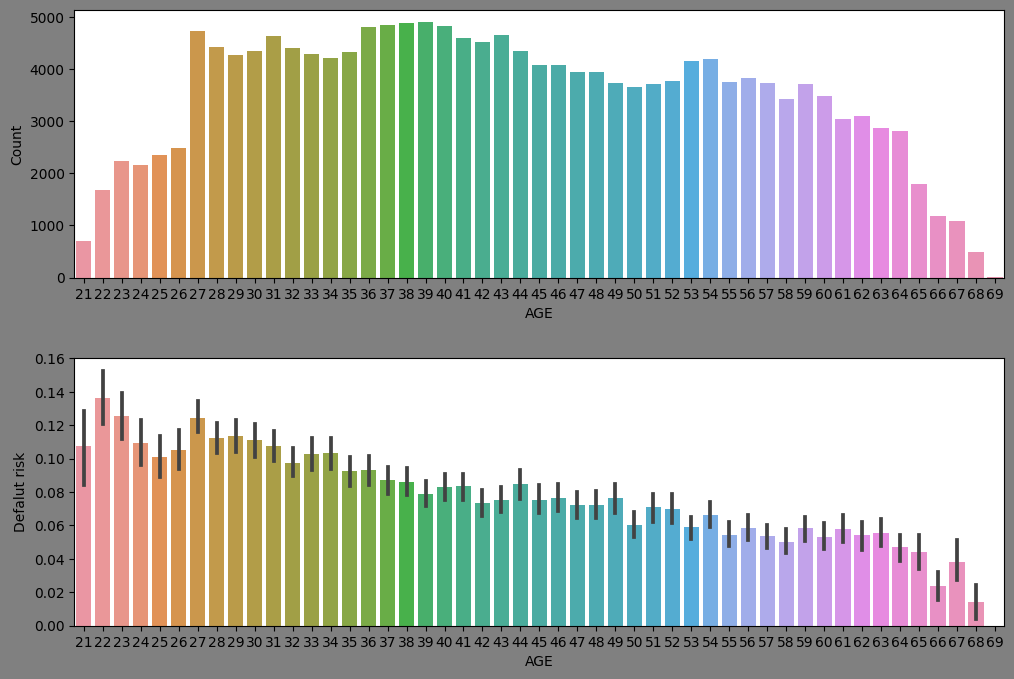

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(12, 8), facecolor="gray")
f.subplots_adjust(hspace=0.3)
sns.countplot(x="AGE", data=train, ax=ax[0])
ax[0].set_ylabel("Count")
sns.barplot(x="AGE", y="TARGET", data=train, ax=ax[1])
ax[1].set_ylabel("Defalut risk")
plt.show()

#### 2.3.3 "X_LABEL"列

In [ ]:
# # "AGE"別でグループ分け
# def get_age_label(age: int) -> int:
#     if (22 <= age <= 23):
#         return 0
#     elif (age == 21 or age == 24 or (27 <= age <= 31)):
#         return 1
#     elif ((25 <= age <= 26) or (32 <= age <= 36)):
#         return 2
#     elif (37 <= age <= 41):
#         return 3
#     elif (42 <= age <= 53):
#         return 4
#     elif (54 <= age <= 64):
#         return 5
#     elif (65 <= age):
#         return 6
#     else:
#         return -999

# train["AGE_LABEL"] = train["AGE"].apply(lambda x: get_age_label(x))
# test["AGE_LABEL"] = test["AGE"].apply(lambda x: get_age_label(x))

In [ ]:
# "NAME_INCOME_TYPE"別でグループ分け
def get_name_income_type_label(name_income_type: str) -> int:
    if ((name_income_type == "Unemployed") or (name_income_type == "Maternity leave")):
        return 0
    elif (name_income_type == "Working"):
        return 1
    elif (name_income_type == "Commercial associate"):
        return 2
    elif (name_income_type == "State servant"):
        return 3
    elif (name_income_type == "Pensioner"):
        return 4
    elif ((name_income_type == "Student") or (name_income_type == "Businessman")):
        return 5
    else:
        return -999

train["NAME_INCOME_TYPE_LABEL"] = train["NAME_INCOME_TYPE"].apply(lambda x: get_name_income_type_label(x))
test["NAME_INCOME_TYPE_LABEL"] = test["NAME_INCOME_TYPE"].apply(lambda x: get_name_income_type_label(x))

# "NAME_INCOME_TYPE"列を削除
train.drop("NAME_INCOME_TYPE", axis=1, inplace=True)
test.drop("NAME_INCOME_TYPE", axis=1, inplace=True)

In [ ]:
# "NAME_EDUCATION_TYPE"別でグループ分け
def get_name_education_type_label(name_education_type: str) -> int:
    if (name_education_type == "Lower secondary"):
        return 0
    elif (name_education_type == "Secondary / secondary special"):
        return 1
    elif (name_education_type == "Incomplete higher"):
        return 2
    elif (name_education_type == "Higher education"):
        return 3
    elif (name_education_type == "Academic degree"):
        return 4
    else:
        return -999

train["NAME_EDUCATION_TYPE_LABEL"] = train["NAME_EDUCATION_TYPE"].apply(lambda x: get_name_education_type_label(x))
test["NAME_EDUCATION_TYPE_LABEL"] = test["NAME_EDUCATION_TYPE"].apply(lambda x: get_name_education_type_label(x))

# "NAME_EDUCATION_TYPE"列を削除
train.drop("NAME_EDUCATION_TYPE", axis=1, inplace=True)
test.drop("NAME_EDUCATION_TYPE", axis=1, inplace=True)

In [ ]:
# # "NAME_FAMILY_STATUS"別でグループ分け
# def get_name_family_status_label(name_family_status: str) -> int:
#     if (name_family_status == "Civil marriage"):
#         return 0
#     elif (name_family_status == "Single / not married"):
#         return 1
#     elif (name_family_status == "Separated"):
#         return 2
#     elif (name_family_status == "Married"):
#         return 3
#     elif (name_family_status == "Widow"):
#         return 4
#     else:
#         return -999

# train["NAME_FAMILY_STATUS_LABEL"] = train["NAME_FAMILY_STATUS"].apply(lambda x: get_name_family_status_label(x))
# test["NAME_FAMILY_STATUS_LABEL"] = test["NAME_FAMILY_STATUS"].apply(lambda x: get_name_family_status_label(x))

# # "NAME_FAMILY_STATUS"列を削除
# train.drop("NAME_FAMILY_STATUS", axis=1, inplace=True)
# test.drop("NAME_FAMILY_STATUS", axis=1, inplace=True)

In [ ]:
# # "NAME_HOUSING_TYPE"別でグループ分け
# def get_name_housing_type_label(name_housing_type: str) -> int:
#     if (name_housing_type == "Rented apartment"):
#         return 0
#     elif (name_housing_type == "With parents"):
#         return 1
#     elif (name_housing_type == "Co-op apartment"):
#         return 2
#     elif (name_housing_type == "Municipal apartment"):
#         return 3
#     elif (name_housing_type == "House / apartment"):
#         return 4
#     elif (name_housing_type == "Office apartment"):
#         return 5
#     else:
#         return -999

# train["NAME_HOUSING_TYPE_LABEL"] = train["NAME_HOUSING_TYPE"].apply(lambda x: get_name_housing_type_label(x))
# test["NAME_HOUSING_TYPE_LABEL"] = test["NAME_HOUSING_TYPE"].apply(lambda x: get_name_housing_type_label(x))

# # "NAME_HOUSING_TYPE"列を削除
# train.drop("NAME_HOUSING_TYPE", axis=1, inplace=True)
# test.drop("NAME_HOUSING_TYPE", axis=1, inplace=True)

#### 2.3.4 "EXT_SOURCES_X"列

In [ ]:
# 各データの統計量
for func_name in ["prod", "min", "max", "mean", "nanmedian", "std"]:
    feat_name = f"EXT_SOURCES_{func_name.upper()}"
    train[feat_name] = eval(f"np.{func_name}")(train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1)
    test[feat_name] = eval(f"np.{func_name}")(test[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]], axis=1)

train["EXT_SOURCES_STD"] = train["EXT_SOURCES_STD"].fillna(train["EXT_SOURCES_STD"].mean())
test["EXT_SOURCES_STD"] = test["EXT_SOURCES_STD"].fillna(test["EXT_SOURCES_STD"].mean())

In [ ]:
# 交差項
train["EXT_SOURCES_PROD_12"] = train["EXT_SOURCE_1"] * train["EXT_SOURCE_2"]
train["EXT_SOURCES_PROD_13"] = train["EXT_SOURCE_1"] * train["EXT_SOURCE_3"]
train["EXT_SOURCES_PROD_23"] = train["EXT_SOURCE_2"] * train["EXT_SOURCE_3"]
test["EXT_SOURCES_PROD_12"] = test["EXT_SOURCE_1"] * test["EXT_SOURCE_2"]
test["EXT_SOURCES_PROD_13"] = test["EXT_SOURCE_1"] * test["EXT_SOURCE_3"]
test["EXT_SOURCES_PROD_23"] = test["EXT_SOURCE_2"] * test["EXT_SOURCE_3"]

In [ ]:
# 重要度に基づき重みを付加
train["EXT_SOURCES_WEIGHT"] = 1 * train["EXT_SOURCE_1"] + 3 * train["EXT_SOURCE_2"] + 2 * train["EXT_SOURCE_3"]
test["EXT_SOURCES_WEIGHT"] = 1 * test["EXT_SOURCE_1"] + 3 * test["EXT_SOURCE_2"] + 2 * test["EXT_SOURCE_3"]

#### 2.3.5 "INCOME_BY_X"列

In [ ]:
# 職業別収入の中央値
income_by_occ = all[["AMT_INCOME_TOTAL", "OCCUPATION_TYPE"]].groupby("OCCUPATION_TYPE")["AMT_INCOME_TOTAL"].median()
income_by_occ.sort_values()

OCCUPATION_TYPE
Cleaning staff           112500.0
Low-skill Laborers       121500.0
Cooking staff            126000.0
Waiters/barmen staff     135000.0
Secretaries              135000.0
Sales staff              135000.0
Medicine staff           135000.0
Security staff           135000.0
Private service staff    157500.0
Laborers                 157500.0
High skill tech staff    157500.0
Core staff               157500.0
HR staff                 158400.0
Accountants              171000.0
Realty agents            180000.0
Drivers                  180000.0
IT staff                 180000.0
Managers                 225000.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [ ]:
train["INCOME_BY_OCC"] = train["OCCUPATION_TYPE"].map(income_by_occ)
test["INCOME_BY_OCC"] = test["OCCUPATION_TYPE"].map(income_by_occ)

In [ ]:
# 職種別収入の中央値
income_by_org = all[["AMT_INCOME_TOTAL", "ORGANIZATION_TYPE"]].groupby("ORGANIZATION_TYPE")["AMT_INCOME_TOTAL"].median()
income_by_org.sort_values()

ORGANIZATION_TYPE
Postal                    112500.00
XNA                       117000.00
Kindergarten              121500.00
Agriculture               126000.00
Industry: type 13         130500.00
Medicine                  135000.00
Restaurant                135000.00
Cleaning                  135000.00
School                    135000.00
Industry: type 3          135000.00
Trade: type 3             135000.00
Government                135000.00
Hotel                     135000.00
Housing                   135000.00
Trade: type 1             137990.25
Industry: type 11         141750.00
Industry: type 6          143100.00
Trade: type 7             144000.00
Self-employed             144000.00
Industry: type 2          148500.00
Industry: type 7          148500.00
Transport: type 3         157500.00
Transport: type 2         157500.00
Transport: type 1         157500.00
Security                  157500.00
Trade: type 2             157500.00
Services                  157500.00
Telecom   

In [ ]:
train["INCOME_BY_ORG"] = train["ORGANIZATION_TYPE"].map(income_by_org)
test["INCOME_BY_ORG"] = test["ORGANIZATION_TYPE"].map(income_by_org)

#### 2.3.6 "INCOME_TO_X_RATIO"

In [ ]:
train["INCOME_TO_PERSON_RATIO"] = train["AMT_INCOME_TOTAL"] / train["CNT_FAM_MEMBERS"]
test["INCOME_TO_PERSON_RATIO"] = test["AMT_INCOME_TOTAL"] / test["CNT_FAM_MEMBERS"]

In [ ]:
train["INCOME_TO_EMPLOYED_RATIO"] = train["AMT_INCOME_TOTAL"] / train["DAYS_EMPLOYED"]
test["INCOME_TO_EMPLOYED_RATIO"] = test["AMT_INCOME_TOTAL"] / test["DAYS_EMPLOYED"]

In [ ]:
train["INCOME_TO_BIRTH_RATIO"] = train["AMT_INCOME_TOTAL"] / train["DAYS_BIRTH"]
test["INCOME_TO_BIRTH_RATIO"] = test["AMT_INCOME_TOTAL"] / test["DAYS_BIRTH"]

In [ ]:
train["INCOME_TO_CREDIT_RATIO"] = train["AMT_INCOME_TOTAL"] / train["AMT_CREDIT"]
test["INCOME_TO_CREDIT_RATIO"] = test["AMT_INCOME_TOTAL"] / test["AMT_CREDIT"]

#### 2.3.7 "GOODS_TO_X_RATIO"列

In [ ]:
train["GOODS_TO_CREDIT_RATIO"] = train["AMT_GOODS_PRICE"] / train["AMT_CREDIT"]
test["GOODS_TO_CREDIT_RATIO"] = test["AMT_GOODS_PRICE"] / test["AMT_CREDIT"]

In [ ]:
train["GOODS_TO_INCOME_RATIO"] = train["AMT_GOODS_PRICE"] / train["AMT_INCOME_TOTAL"]
test["GOODS_TO_INCOME_RATIO"] = test["AMT_GOODS_PRICE"] / test["AMT_INCOME_TOTAL"]

#### 2.3.8 "ANNUITY_TO_X_RATIO"列

In [ ]:
train["ANNUITY_TO_INCOME_RATIO"] = train["AMT_ANNUITY"] / train["AMT_INCOME_TOTAL"]
test["ANNUITY_TO_INCOME_RATIO"] = test["AMT_ANNUITY"] / test["AMT_INCOME_TOTAL"]

In [ ]:
train["ANNUITY_TO_CREDIT_RATIO"] = train["AMT_ANNUITY"] / train["AMT_CREDIT"]
test["ANNUITY_TO_CREDIT_RATIO"] = test["AMT_ANNUITY"] / test["AMT_CREDIT"]

#### 2.3.9 "EMPLOYED_TO_BIRTH_RATIO"列

In [ ]:
train["EMPLOYED_TO_BIRTH_RATIO"] = train["DAYS_EMPLOYED"] / train["DAYS_BIRTH"]
test["EMPLOYED_TO_BIRTH_RATIO"] = test["DAYS_EMPLOYED"] / test["DAYS_BIRTH"]

#### 2.3.10 "PUBLISH_TO_BIRTH_RATIO"列

In [ ]:
train["PUBLISH_TO_BIRTH_RATIO"] = train["DAYS_ID_PUBLISH"] / train["DAYS_BIRTH"]
test["PUBLISH_TO_BIRTH_RATIO"] = test["DAYS_ID_PUBLISH"] / test["DAYS_BIRTH"]

#### 2.3.11 "CAR_TO_X_RATIO"列

In [ ]:
train["CAR_TO_BIRTH_RATIO"] = train["OWN_CAR_AGE"] / train["DAYS_BIRTH"]
test["CAR_TO_BIRTH_RATIO"] = test["OWN_CAR_AGE"] / test["DAYS_BIRTH"]

In [ ]:
train["CAR_TO_EMPLOYED_RATIO"] = train["OWN_CAR_AGE"] / train["DAYS_EMPLOYED"]
test["CAR_TO_EMPLOYED_RATIO"] = test["OWN_CAR_AGE"] / test["DAYS_EMPLOYED"]

#### 2.3.12 "PHONE_TO_BIRTH_RATIO"列

In [ ]:
train["PHONE_TO_BIRTH_RATIO"] = train["DAYS_LAST_PHONE_CHANGE"] / train["DAYS_BIRTH"]
test["PHONE_TO_BIRTH_RATIO"] = test["DAYS_LAST_PHONE_CHANGE"] / test["DAYS_BIRTH"]

### 2.4 カテゴリカル変数に対しての処理

#### 2.4.1 Label Encoding

In [ ]:
def label_encoder(df: DataFrame, cols: List[str], use_na_sentinel: bool=True) -> DataFrame:
    for col in cols:
        df[col], _ = pd.factorize(df[col], use_na_sentinel=use_na_sentinel)
        df[col] = np.where(df[col] == -1, np.nan, df[col])

    return df

In [ ]:
# 二値化する特徴量
label_fe = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]

train = label_encoder(train, label_fe)
test = label_encoder(test, label_fe)

#### 2.4.2 One-Hot Encodeing

In [ ]:
# # "REGION_RATING_CLIENT"と"REGION_RATING_CLIENT_W_CITY"を文字列型に変換
# train["REGION_RATING_CLIENT"] = train["REGION_RATING_CLIENT"].astype(str)
# train["REGION_RATING_CLIENT_W_CITY"] = train["REGION_RATING_CLIENT_W_CITY"].astype(str)
# test["REGION_RATING_CLIENT"] = test["REGION_RATING_CLIENT"].astype(str)
# test["REGION_RATING_CLIENT_W_CITY"] = test["REGION_RATING_CLIENT_W_CITY"].astype(str)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171196 entries, 0 to 171201
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171196 non-null  int64  
 1   TARGET                       171196 non-null  int64  
 2   NAME_CONTRACT_TYPE           171196 non-null  float64
 3   CODE_GENDER                  171196 non-null  float64
 4   FLAG_OWN_CAR                 136956 non-null  float64
 5   FLAG_OWN_REALTY              136956 non-null  float64
 6   CNT_CHILDREN                 171196 non-null  int64  
 7   AMT_INCOME_TOTAL             171196 non-null  float64
 8   AMT_CREDIT                   171196 non-null  float64
 9   AMT_ANNUITY                  171190 non-null  float64
 10  AMT_GOODS_PRICE              171035 non-null  float64
 11  NAME_TYPE_SUITE              170451 non-null  object 
 12  NAME_FAMILY_STATUS           171196 non-null  object 
 13 

In [ ]:
def one_hot_encoder(df: DataFrame, drop_first: bool=False, nan_as_category: bool=False) -> DataFrame:
    categorical_cols = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=drop_first, dummy_na=nan_as_category)

    return df

In [ ]:
train = one_hot_encoder(train)
test = one_hot_encoder(test)

### 2.5 特徴量の削除

In [ ]:
print(f"train shape = {train.shape}")
print(f"test shape = {test.shape}")

train shape = (171196, 189)
test shape = (61500, 188)


In [ ]:
# # LightGBMの重要度が低い特徴量を返す関数
# def lightgbm_feature_selection(train_df: DataFrame, auc_limit: float) -> List[str]:
#     lgbm = LGBMClassifier(random_state=0)
#     X_train_df = train_df.drop(["SK_ID_CURR", "TARGET"], axis=1)
#     y_train_df = train_df["TARGET"]
#     train_columns = X_train_df.columns

#     max_auc_score = 1
#     best_cols = []
#     while max_auc_score > auc_limit:
#         train_columns = [col for col in train_columns if col not in best_cols]
#         lgbm.fit(X_train_df[train_columns].values, y_train_df.values)
#         feats_importance = pd.Series(lgbm.feature_importances_, index=train_columns)
#         max_auc_score = roc_auc_score(y_train_df.values, lgbm.predict_proba(X_train_df[train_columns].values)[:, 1])
#         best_cols = feats_importance[feats_importance > 0].index.tolist()

#     return train_columns

In [ ]:
# low_columns = lightgbm_feature_selection(train, 0.6)
# print(low_columns)

In [ ]:
# # 全特徴量を出力
# i = 0
# for column in train.columns:
#     i += 1
#     print(f'"{column}", ', end="")
#     if (i % 10 == 0):
#         print()

In [ ]:
# 削除する特徴量を選択
# "AGE"は"DAYS_BIRTH"があるから削除
# 1.6より数が少ない特徴量や債務不履行リスクの違いが少ない特徴量
# 3.4より重要度が低い特徴量
del_fe = ["AGE", "FLAG_MOBIL", "FLAG_CONT_MOBILE", "FLAG_EMAIL"]

# 特徴量を削除
train.drop(del_fe, axis=1, inplace=True)
test.drop(del_fe, axis=1, inplace=True)

In [ ]:
print(f"train shape = {train.shape}")
print(f"test shape = {test.shape}")

train shape = (171196, 185)
test shape = (61500, 184)


## 3\. LightGBMモデル構築

### 3.1 変数の準備
- 説明変数："SK_ID_CURR", "TARGET"以外の変数  
- 目的変数："TARGET"

In [ ]:
# X:説明変数  y:目的変数
X = train.drop(["SK_ID_CURR", "TARGET"], axis=1).values
y = train["TARGET"].values
X_test = test.drop("SK_ID_CURR", axis=1).values

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### 3.2 Optunaを利用したハイパーパラメータチューニング

In [ ]:
# def objective(trial):
#     params = {
#         "num_leaves": trial.suggest_int("num_leaves", 4, 64),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
#         "n_estimators": trial.suggest_int("n_estimators", 1000, 5000, step=1000),
#         "objective": "binary",
#         "metric": "auc",
#         "min_split_gain": trial.suggest_float("min_split_gain", 0.001, 0.03, step=0.001),
#         "min_child_samples": trial.suggest_int("min_child_samples", 16, 256),
#         "subsample": trial.suggest_float("subsample", 0.4, 0.9, step=0.001),
#         "subsample_freq": trial.suggest_int("subsample_freq", 1, 6),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.9, step=0.001),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 5.0, log=True),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 5.0, log=True),
#         "n_jobs": -1,
#         "verbosity": -1
#     }

#     lgbm = LGBMClassifier(**params, random_state=42)
#     lgbm.fit(X_train, y_train)

#     y_pred_proba = lgbm.predict_proba(X_eval)[:, 1]
#     val = roc_auc_score(y_eval, y_pred_proba)

#     return val

In [ ]:
# # Optunaを実行
# study = optuna.create_study(direction="maximize", study_name="LGBM Classifier", sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=300)

# # 最適パラメータの表示と保持
# best_params = study.best_trial.params
# best_score = study.best_trial.value
# print(f"最適パラメータ {best_params}\nスコア {best_score}")

In [ ]:
# # Optunaの最適パラメータ
# params = {
#     "num_leaves": best_params["num_leaves"],
#     "max_depth": best_params["max_depth"],
#     "learning_rate": best_params["learning_rate"],
#     "n_estimators": best_params["n_estimators"],
#     "objective": "binary",
#     "metric": "auc",
#     "min_split_gain": best_params["min_split_gain"],
#     "min_child_samples": best_params["min_child_samples"],
#     "subsample": best_params["subsample"],
#     "subsample_freq": best_params["subsample_freq"],
#     "colsample_bytree": best_params["colsample_bytree"],
#     "reg_alpha": best_params["reg_alpha"],
#     "reg_lambda": best_params["reg_lambda"],
#     "n_jobs": -1,
#     "verbosity": -1
# }

In [ ]:
# 探索範囲を狭めていき最終的に得られた最適パラメータ
params = {
    "num_leaves": 17,
    "max_depth": 6,
    "learning_rate": 0.01,
    "n_estimators": 4000,
    "objective": "binary",
    "metric": "auc",
    "min_split_gain": 0.02,
    "min_child_samples": 196,
    "subsample": 0.84,
    "subsample_freq": 1,
    "colsample_bytree": 0.486,
    "reg_alpha": 2.8498005860203866,
    "reg_lambda": 0.8913447647450139,
    "n_jobs": -1,
    "verbosity": -1
}

### 3.3 学習

In [ ]:
# # folds = KFold(n_splits=7, shuffle=True, random_state=42)
# folds = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# # 結果を記録する配列
# oof_preds = np.zeros(train.shape[0])  # Out of Fold
# submission_preds = np.zeros(test.shape[0])
# feature_importance_df = DataFrame()

# for n_fold, (train_idx, valid_idx) in enumerate(list(folds.split(X, y))):
#     X_train, y_train = X[train_idx], y[train_idx]
#     X_valid, y_valid = X[valid_idx], y[valid_idx]

#     lgbm = LGBMClassifier(**params, early_stopping_rounds=500, importance_type="gain", random_state=42)
#     lgbm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric="auc")

#     oof_preds[valid_idx] = lgbm.predict_proba(X_valid, num_iteration=lgbm.best_iteration_)[:, 1]
#     submission_preds += lgbm.predict_proba(X_test, num_iteration=lgbm.best_iteration_)[:, 1] / folds.n_splits

#     fold_importance_df = DataFrame()
#     fold_importance_df["feature"] = train.drop(["SK_ID_CURR", "TARGET"], axis=1).columns
#     fold_importance_df["importance"] = lgbm.feature_importances_
#     fold_importance_df["fold"] = n_fold + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     print(f"Fold: {n_fold + 1}  AUC: {roc_auc_score(y_valid, oof_preds[valid_idx])}")

# print(f"Full AUC score: {roc_auc_score(y, oof_preds)}")

In [ ]:
# 全trainデータで学習
lgbm_best = LGBMClassifier(**params, importance_type="gain", random_state=42)
lgbm_best.fit(X, y)

feature_importance_df = DataFrame()
feature_importance_df["feature"] = train.drop(["SK_ID_CURR", "TARGET"], axis=1).columns
feature_importance_df["importance"] = lgbm_best.feature_importances_

submission_preds = lgbm_best.predict_proba(X_test)[:, 1]

### 3.4 特徴量の重要度を可視化

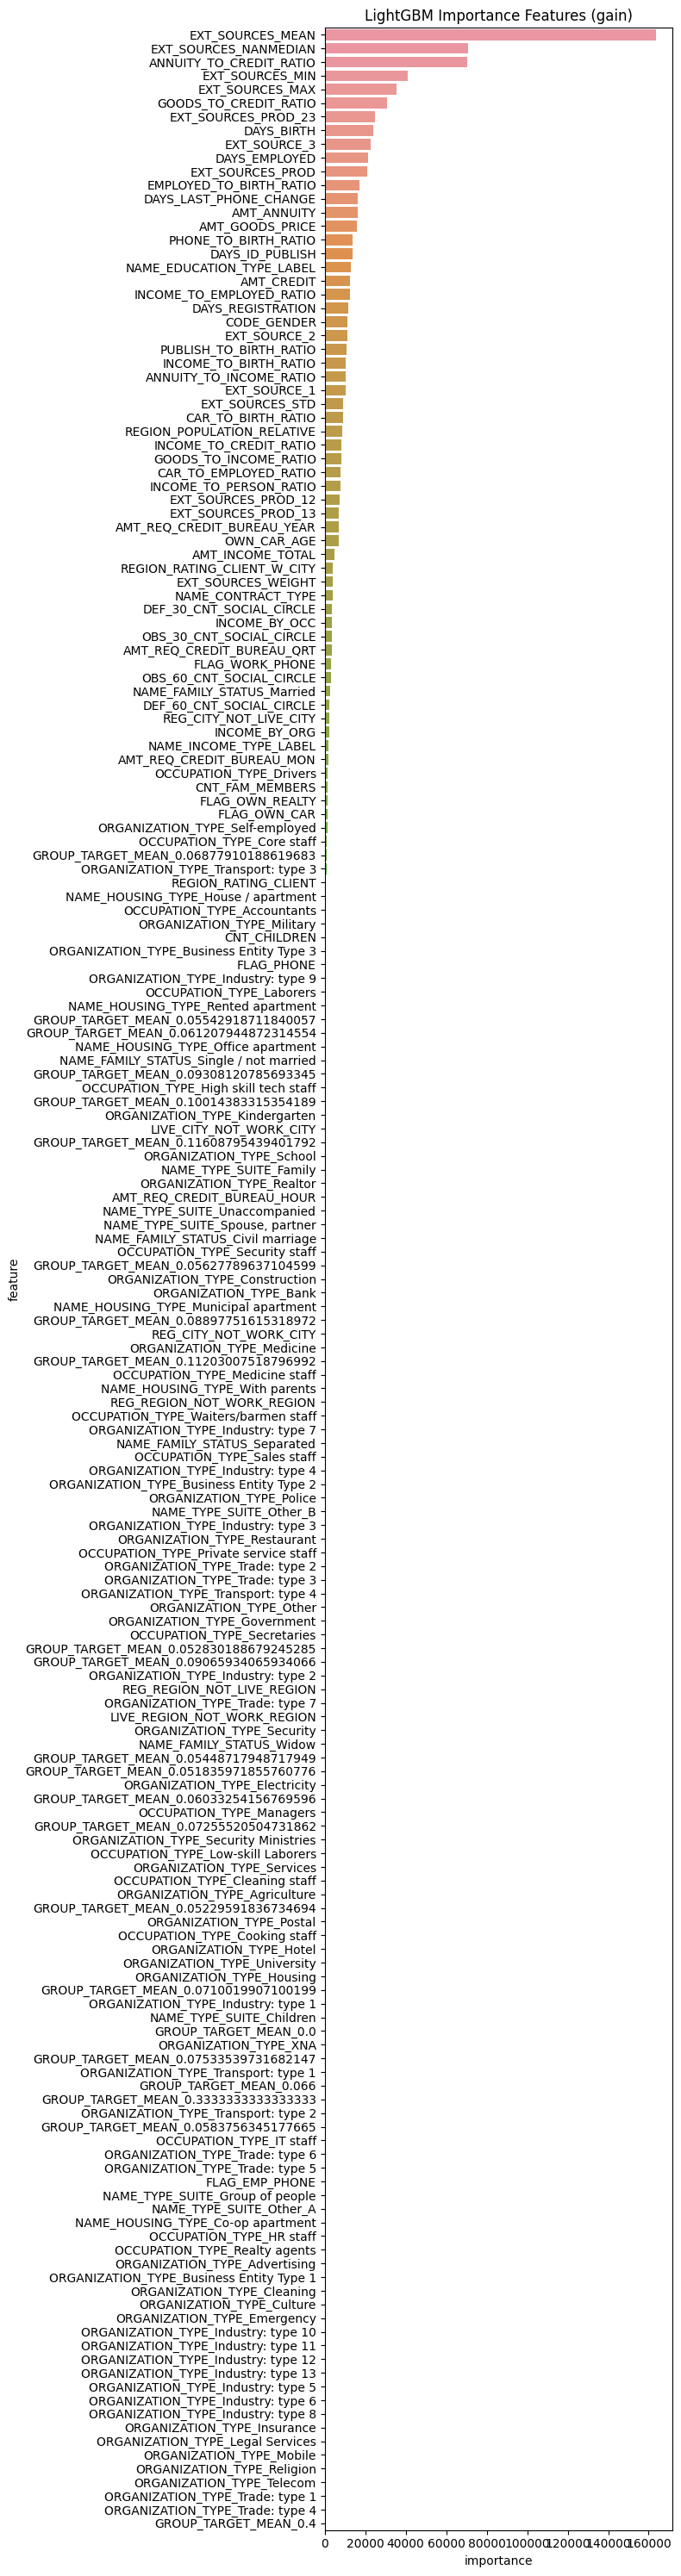

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8, 30))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Importance Features (gain)')
plt.tight_layout()
# plt.savefig("lgbm_importances.png")

## 4\. 提出ファイル作成

In [ ]:
# ファイルをセッションストレージにアップロード
submission = pd.read_csv("sample_submission.csv")

print(submission.shape)
print(submission_preds.shape)

(61500, 2)
(61500,)


In [ ]:
# 予測結果を提出用のフォーマットに格納
submission["TARGET"] = submission_preds
submission.head()

,SK_ID_CURR,TARGET
0,171202,0.023661
1,171203,0.201151
2,171204,0.177909
3,171205,0.091326
4,171206,0.207527


In [ ]:
# 提出用のcsvファイルを作成
submission.to_csv("submission.csv", index=False)

## 参考文献
- https://www.kaggle.com/code/nozomuk/home-credit-complete-eda/notebook
- https://www.kaggle.com/code/hikmetsezen/base-model-with-0-804-auc-on-home-credit
- https://www.kaggle.com/code/omarkhd99/home-credit-default-risk-challeng
- https://www.kaggle.com/competitions/home-credit-default-risk/discussion/64821